# Mount the Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Import Packages

In [0]:
!pip install h2o
!pip install boruta

In [0]:
#Basic
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
from scipy.stats import skew

import ast
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

import xgboost as xgb
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import math 

# Import Data

In [0]:
link ='https://drive.google.com/open?id=12Zr8bnc38YUnbDrIOxyPpFhtFVym9GRn'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_hotel.csv')  
df_hotel = pd.read_csv('df_hotel.csv')

link ='https://drive.google.com/open?id=1RRdIO8txsy_tvywv8rdi1rHQbCtqkhld'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df.csv')  
df = pd.read_csv('df.csv')

df['is_cross_sell']=df['hotel_id'].apply(lambda x: 'Yes' if x !='None' else 'No')

12Zr8bnc38YUnbDrIOxyPpFhtFVym9GRn


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

1RRdIO8txsy_tvywv8rdi1rHQbCtqkhld


In [0]:
df.head()

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,route,hotel_id,visited_city,log_transaction,is_cross_sell
0,912aa410a02cd7e1bab414214a7005c0,5c6f39c690f23650d3cde28e5b51c908,566.0,M,trip,ECONOMY,885898.00,NO,1.0,33199710eb822fbcfd0dc793f4788d30,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[545203.03, 918492.11, 1774241.4, 885898.0]'",No
1,d64a90a618202a5e8b25d8539377f3ca,5cbef2b87f51c18bf399d11bfe495a46,607.0,M,trip,ECONOMY,2139751.25,NO,2.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jakarta', 'Medan', 'Bali']'","'[555476.36, 2422826.84, 7398697.64, 7930866.8...",No
2,1a42ac02bcb4a902973123323f84da55,38fc35a1e62384012a358ab1fbd5ad03,648.0,F,trip,ECONOMY,2695550.00,NO,1.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[7328957.45, 7027662.34, 1933360.88, 3461836....",No
3,92cddd64d4be4dec6dfbcc0c50e902f4,c7f54cb748828b4413e02dea2758faf6,418.0,F,trip,ECONOMY,1146665.00,NO,1.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jogjakarta', 'Bali', 'Jakarta', 'Medan']'","'[5243631.69, 2474344.48, 1146665.0]'",No
4,bf637abc47ea93bad22264f4956d67f6,dec228e4d2b6023c9f1fe9cfe9c451bf,537.0,F,trip,ECONOMY,1131032.50,NO,1.0,6c483c0812c96f8ec43bb0ff76eaf716,CGK - DPS,None,"'['Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'S...","'[9808972.98, 9628619.79, 6712680.0, 5034510.0...",No


# Function Definition

In [0]:
def ordering_label(df,target,feat):
  '''
  Function for ordering categorical features based on Target feature
  '''
  data=df.copy()
  data[target]=data[target].apply(lambda x: 1 if x=='Yes' else 0)
  ordered_labels = data.groupby(feat).mean()[target].sort_values().index
  ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
  df[feat]=df[feat].map(ordinal_label)
  return(df)

def detailed_segmentation(df_train,df_val,columns,target,num_segments):
  '''
  Function for detailed segmentation
    
  Number of segments which is not the multiple of 2 will be round down to the nearest
  whole number
  '''
  depth=math.floor(math.log2(num_segments))
  X_train=df_train.drop(target,1)
  y_train=df_train[[target]]
  X_val=df_val.drop(target,1)

  tree_model = DecisionTreeClassifier(max_depth=depth)
    
  for column in columns:
    tree_model.fit(X_train[[column]], y_train)
    df_train[column+'detailed_segment'] = tree_model.predict_proba(X_train[[column]])[:,1]
    df_train=ordering_label(df_train,target,column+'detailed_segment')
    df_val[column+'detailed_segment'] = tree_model.predict_proba(X_val[[column]])[:,1]
    df_val=ordering_label(df_val,target,column+'detailed_segment')
    df_train=df_train.drop(column,1)
    df_val=df_val.drop(column,1)
  return(df_train,df_val)

def mean_encoding(df_train,df_val,columns,target,adjusted=False):
  '''
  Function to create mean encoding
  '''
  train=df_train.copy()
  train[target]=train[target].apply(lambda x: 1 if x=='Yes' else 0)
  for column in columns:
    a = pd.DataFrame(train.groupby([column])[target].mean())
    if adjusted:
      b=pd.DataFrame(train.groupby([column])['is_cross_sell'].count())
      prob_df=a.merge(b,on=column)
      prob_df=prob_df.rename(columns={"is_cross_sell_x": "is_cross_sell", "is_cross_sell_y": "count"})
      prob_df['mean']=np.log(1+prob_df['count'])*prob_df['is_cross_sell']
    else:
      prob_df=a.copy()
      prob_df['mean']=prob_df['is_cross_sell']
    ordered_labels = prob_df['mean'].to_dict()
    df_train[column+'_mean_encoding'] = df_train[column].map(ordered_labels)
    #if there is no historical data before then probability of success is assumed same as in the training set
    train_mean=df_train[target].value_counts()['Yes']/len(df_train[target])
    df_val[column+'_mean_encoding'] = df_val[column].apply(lambda x: ordered_labels[x] if x in ordered_labels 
                                                           else (df_train[target].value_counts()['Yes'])/len(df_train[target]))
    df_train=df_train.drop(column,1)
    df_val=df_val.drop(column,1)
  return(df_train,df_val)

def WoE(df_train,df_val,columns,target,adjusted=False):
  '''
  Function to create Weight of Evidence
  '''
  train=df_train.copy()
  train[target]=train[target].apply(lambda x: 1 if x=='Yes' else 0)
  for column in columns:
    a = pd.DataFrame(train.groupby([column])[target].mean())
    if adjusted:
      b=pd.DataFrame(train.groupby([column])['is_cross_sell'].count())
      prob_df=a.merge(b,on=column)
      prob_df=prob_df.rename(columns={"is_cross_sell_x": "is_cross_sell", "is_cross_sell_y": "count"})
    else:
      prob_df=a.copy()
    prob_df['not_'+target] = 1-prob_df[target]
    prob_df[prob_df[target] == 0] = 0.000001
    # prob_df[prob_df['not_'+target] == 0] = 0.000001
    if adjusted:
      prob_df['WoE'] = np.log(1+prob_df['count'])*np.log(prob_df[target]/prob_df['not_'+target])
    else:
      prob_df['WoE'] = np.log(prob_df[target]/prob_df['not_'+target])
    ordered_labels = prob_df['WoE'].to_dict()

    df_train[column+'_WoE'] = df_train[column].map(ordered_labels)
    #if there is no historical data before then probability of success is assumed same as in the training set
    df_val[column+'_WoE'] = df_val[column].apply(lambda x: ordered_labels[x] if x in ordered_labels else 
                                                 np.log((0.000001+df_train[target].value_counts()['Yes'])/(df_train[target].value_counts()['No'])) if df_train[target].value_counts()['Yes']==0 else
                                                  np.log((df_train[target].value_counts()['Yes'])/(0.000001+df_train[target].value_counts()['No'])))
    df_train=df_train.drop(column,1)
    df_val=df_val.drop(column,1)
  return(df_train,df_val)

def PCA(df,columns,n_components,scaled=True):
  pca_model = PCA(n_components=n_components)
  if scaled==False:
    scaled_X=rescaling(df,columns,scale_type='Standard')
  else:
    scaled_X=df[columns].copy()
  df_pca = pca_model.fit_transform(scaled_X)
  df_pca=pd.DataFrame(df_pca)
  print('Variance Explained: {}'.format(pca_model.explained_variance_ratio_.cumsum()))
  return(df_pca)

def rescaling(df,columns,scale_type='Standard'):
  '''
  Function for Feature Scaling
  '''
  scale_type=scale_type.lower()
  scaled_X=df.drop(columns,1)
  X=df[columns]
  
  if scale_type=='minmax':
    scaler=MinMaxScaler(feature_range=(0,1))
  elif scale_type=='standard':
    scaler=StandardScaler()

  scaled_column=scaler.fit_transform(X)
  scaled_column=pd.DataFrame(scaled_column,columns=columns)
  for column in columns:
    scaled_X[column]=scaled_column[column].tolist()
  
  return(scaled_X)

def PCA(df,columns,n_components,scaled=True):
  pca_model = PCA(n_components=n_components)
  if scaled==False:
    scaled_X=rescaling(df,columns,scale_type='Standard')
  else:
    scaled_X=df[columns].copy()
  df_pca = pca_model.fit_transform(scaled_X)
  df_pca=pd.DataFrame(df_pca)
  print('Variance Explained: {}'.format(pca_model.explained_variance_ratio_.cumsum()))
  return(df_pca)

def elbow_plot_kmeans(df,columns,kmax,step,scaled=True):
  '''
  Function for kMeans elbow plot
  
  kmax is maximum number of k
  step is looping step for testing kmeans
  '''
  if scaled==False:
    X=rescaling(df,columns,scale_type='Standard')
  else:
    X=df.copy()
  
  WCSS=[]
  for i in range(1,kmax,step):
    kmeans=MiniBatchKMeans(n_clusters=i,init='k-means++',random_state=100,verbose=False)
    kmeans.fit(X)
    WCSS.append(kmeans.inertia_)
    
  plt.plot(range(1,kmax,step),WCSS)
  plt.title('Elbow Method')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.xlim([0,kmax])
  plt.show()

def kmeans(df,columns,k,scaled=True,plot=True):
  '''
  Function for kMeans segmentation
  '''
  if scaled==False:
    X=rescaling(df,columns,scale_type='Standard')
  else:
    X=df[columns].copy()
    
  kmeans=MiniBatchKMeans(n_clusters=k ,init='k-means++',random_state=100,verbose=False)
  y=kmeans.fit(X)
  df['label']=y.labels_.tolist()
  
  if plot==True:
    if len(columns)>2:
      pca = PCA(n_components=3)
      df_pca = pca.fit_transform(X)
      df_pca=pd.DataFrame(df_pca,columns=['pca_1','pca_2','pca_3'])
      fig=plt.figure()
      ax=plt.axes(projection="3d")
      scatter=ax.scatter3D(df_pca.loc[:,'pca_1'],df_pca.loc[:,'pca_2'],df_pca.loc[:,'pca_3'],c=y.labels_,cmap='hsv')
      plt.colorbar(scatter)
      plt.title(str(k)+'-Means Clustering')
      plt.show()
    else:
      scatter=plt.scatter(df.loc[:,columns[0]],df.loc[:,columns[1]],c=y.labels_)
      plt.xlabel(columns[0])
      plt.ylabel(columns[1])
      plt.title(str(k)+'-Means Clustering')
      plt.show()
  return(df)

def segmentation(df_train,df_val,k=9):
  toy=df_train.copy()
  toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
  df_seg=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
  df_seg['count']=toy.groupby('account_id').count()['member_duration_days']
  df_seg=df_seg.rename({'member_duration_days':'count'})
  df_seg=kmeans(df_seg[df_seg['count']<20],columns=['is_cross_sell','count'],k=k,scaled=False,plot=False)
  df_seg=ordering_label(df_seg,target='is_cross_sell',feat='label')
  acc_0=df_seg[df_seg.label==0].index.tolist()
  acc_1=df_seg[df_seg.label==1].index.tolist()
  acc_2=df_seg[df_seg.label==2].index.tolist()
  acc_3=df_seg[df_seg.label==3].index.tolist()
  acc_4=df_seg[df_seg.label==4].index.tolist()
  acc_5=df_seg[df_seg.label==5].index.tolist()
  acc_6=df_seg[df_seg.label==6].index.tolist()
  acc_7=df_seg[df_seg.label==7].index.tolist()
  acc_8=df_seg[df_seg.label==8].index.tolist()
  acc_9=df_seg[df_seg['count']>=20].index.tolist()
  df_train['segment']=df_train.account_id.apply(lambda x: 0 if x in acc_0 else 1 if x in acc_1 else 
                                                2 if x in acc_2 else 3 if x in acc_3 else 4 if x in acc_4 else 5 if x in acc_5 else 
                                                6 if x in acc_6 else 7 if x in acc_7 else 8 if x in acc_8 else 9)
  df_val['segment']=df_val.account_id.apply(lambda x: 0 if x in acc_0 else 1 if x in acc_1 else 
                                                2 if x in acc_2 else 3 if x in acc_3 else 4 if x in acc_4 else 5 if x in acc_5 else 
                                                6 if x in acc_6 else 7 if x in acc_7 else 8 if x in acc_8 else 9 if x in acc_9 else
                                                np.nan)
  return(df_train,df_val)

# Data Cleaning

In [0]:
df['airlines_name'].value_counts()

6c483c0812c96f8ec43bb0ff76eaf716    36669
33199710eb822fbcfd0dc793f4788d30    30640
0a102015e48c1f68e121acc99fca9a05    20928
ad5bef60d81ea077018f4d50b813153a    11890
74c5549aa99d55280a896ea50068a211    10751
e35de6a36d385711a660c72c0286154a     7060
9855a1d3de1c46526dde37c5d6fb758c        6
6872b49542519aea7ae146e23fab5c08        2
Name: airlines_name, dtype: int64

In [0]:
df['airlines_name'].value_counts()

6c483c0812c96f8ec43bb0ff76eaf716    36669
33199710eb822fbcfd0dc793f4788d30    30640
0a102015e48c1f68e121acc99fca9a05    20928
ad5bef60d81ea077018f4d50b813153a    11890
74c5549aa99d55280a896ea50068a211    10751
e35de6a36d385711a660c72c0286154a     7060
9855a1d3de1c46526dde37c5d6fb758c        6
6872b49542519aea7ae146e23fab5c08        2
Name: airlines_name, dtype: int64

In [0]:
df['gender']=df['gender'].apply(lambda x: 'M' if x=='None' else x)
df['trip']=df['trip'].apply(lambda x: 'round' if x=='roundtrip' else x)
df['airlines_name']=df['airlines_name'].apply(lambda x: 'A' if x=='6c483c0812c96f8ec43bb0ff76eaf716' else 'B' if x=='33199710eb822fbcfd0dc793f4788d30' else 'C' if x=='0a102015e48c1f68e121acc99fca9a05' else 
                          'D' if x=='ad5bef60d81ea077018f4d50b813153a' else 'E' if x=='74c5549aa99d55280a896ea50068a211' else 'F' if x=='e35de6a36d385711a660c72c0286154a' else 'G' if x=='9855a1d3de1c46526dde37c5d6fb758c' else 'H')
df=df[(df['airlines_name']!='G') & (df['airlines_name']!='H') & (df['account_id']!='d64a90a618202a5e8b25d8539377f3ca')]
df=df.reset_index()
df=df.drop(['route','index'],1)

df_hotel=df_hotel.drop('city',1)

# Feature Engineering

In [0]:
df['log_transaction']=df['log_transaction'].apply(lambda x: ast.literal_eval(x))
df['log_transaction']=df['log_transaction'].apply(lambda x: ast.literal_eval(x))
print('Checking Negative Trx: ')
print(df['log_transaction'].apply(lambda x: "Negative" if any(k<0 for k in x) else "Positive").value_counts())
df['is_refund']=df['log_transaction'].apply(lambda x: "Yes" if any(k<0 for k in x) else "No")
df['min_trx']=df['log_transaction'].apply(lambda x: np.min(x))
df['max_trx']=df['log_transaction'].apply(lambda x: np.max(x))
df['avg_trx']=df['log_transaction'].apply(lambda x: np.mean(x))
df['std_trx']=df['log_transaction'].apply(lambda x: np.std(x))
df['cnt_trx']=df['log_transaction'].apply(lambda x: len(x))
# df['skew_trx']=df['log_transaction'].apply(lambda x: skew(x))
# df['Last_trx']=df['log_transaction'].apply(lambda x: x[-1])

df['visited_jogja']=df['visited_city'].apply(lambda x: 1 if 'Jogjakarta' in x else 0)
df['visited_semarang']=df['visited_city'].apply(lambda x: 1 if 'Semarang' in x else 0)
df['visited_surabaya']=df['visited_city'].apply(lambda x: 1 if 'Surabaya' in x else 0)
df['visited_aceh']=df['visited_city'].apply(lambda x: 1 if 'Aceh' in x else 0)
df['visited_manado']=df['visited_city'].apply(lambda x: 1 if 'Manado' in x else 0)

df['adj_price']=df['price']/(df['no_of_seats'])
df['adj_price']=df.apply(lambda x: (x.adj_price)/2 if x.trip=='round' else x.adj_price ,axis=1)

# adj_price_threshold=np.mean(df[(df.is_tx_promo=='No') & (df.is_cross_sell=='No')]['adj_price'])
# df['is_tx_promo']=df.apply(lambda x: 'No_below' if (x.is_tx_promo=='No') & (x.adj_price < adj_price_threshold) else 'No_upper' if (x.is_tx_promo=='No') & (x.adj_price >= adj_price_threshold) else x.is_tx_promo,axis=1)

an = df.airlines_name.unique()
sc = df.service_class.unique()
a=dict()
for i in an:
  for j in sc:
    mean_g = np.mean(df[(df.airlines_name==i)&(df.service_class==j)&(df.is_tx_promo=='NO')]['adj_price'])
    a[i+'_'+j]=mean_g
df['price_dif']=df.apply(lambda x : ((x.adj_price) - a['A_ECONOMY']) if ((x.airlines_name=='A') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['B_ECONOMY']) if ((x.airlines_name=='B') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['C_ECONOMY']) if ((x.airlines_name=='C') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['D_ECONOMY']) if ((x.airlines_name=='D') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['E_BUSINESS']) if ((x.airlines_name=='E') & (x.service_class=='BUSINESS')) else 
                         ((x.adj_price) - a['E_ECONOMY']) if ((x.airlines_name=='E') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['F_ECONOMY']) if ((x.airlines_name=='F') & (x.service_class=='ECONOMY')) else 
                         np.nan ,axis=1)
# df['adj_trx']=(df.cnt_trx)/(df.member_duration_days)

# df['is_tx_promo']=df['is_tx_promo'].apply(lambda x: 1 if x=='YES' else 0)
# df['trip']=df['trip'].apply(lambda x: 1 if x=='trip' else 0)
# df['gender']=df['gender'].apply(lambda x: 1 if x=='M' else 0)
# df['service_class']=df['service_class'].apply(lambda x: 1 if x=='ECONOMY' else 0)
# df['is_refund']=df['is_refund'].apply(lambda x: 0 if x=='No' else 1)
df=df.drop(['log_transaction','visited_city','hotel_id','order_id'],1)

# df['logmember']=df['member_duration_days'].apply(lambda x : math.log(x))
# df['logadj']=df['adj_price'].apply(lambda x : math.log(x))

# df=df.drop(['member_duration_days','adj_price'],axis=1)


Checking Negative Trx: 
Positive    114540
Negative        87
Name: log_transaction, dtype: int64


In [0]:
df.head()

,account_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,is_cross_sell,is_refund,min_trx,max_trx,avg_trx,std_trx,cnt_trx,visited_jogja,visited_semarang,visited_surabaya,visited_aceh,visited_manado,adj_price,price_dif
0,912aa410a02cd7e1bab414214a7005c0,566.0,M,trip,ECONOMY,885898.0,NO,1.0,B,No,No,545203.03,1774241.40,1.030959e+06,4.533539e+05,4,0,1,0,0,0,885898.0,-3.502775e+05
1,1a42ac02bcb4a902973123323f84da55,648.0,F,trip,ECONOMY,2695550.0,NO,1.0,C,No,No,1933360.88,7328957.45,4.489474e+06,2.250021e+06,5,0,1,0,0,0,2695550.0,1.382226e+06
2,92cddd64d4be4dec6dfbcc0c50e902f4,418.0,F,trip,ECONOMY,1146665.0,NO,1.0,C,No,No,1146665.00,5243631.69,2.954880e+06,1.706745e+06,3,1,0,0,0,0,1146665.0,-1.666595e+05
3,bf637abc47ea93bad22264f4956d67f6,537.0,F,trip,ECONOMY,1131032.5,NO,1.0,A,No,No,951639.00,13563940.00,4.362199e+06,3.006539e+06,157,1,1,0,0,0,1131032.5,-1.017806e+05
4,fdd499437b284d3c410ba3dfba4fe810,493.0,M,trip,ECONOMY,1457118.0,NO,1.0,D,No,No,1457118.00,7409996.26,5.302909e+06,2.723540e+06,3,0,0,0,0,0,1457118.0,2.025159e+05


In [0]:
df[df['account_id']=='fbb4123bb341ad85719af86930a0ccea']['is_cross_sell'].describe()

count     311
unique      1
top        No
freq      311
Name: is_cross_sell, dtype: object

# Model

### Model 1

In [0]:
drop_columns=['service_class','gender','price','is_refund','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado']
df.drop(columns=drop_columns).columns

Index(['account_id', 'member_duration_days', 'trip', 'is_tx_promo',
       'no_of_seats', 'airlines_name', 'is_cross_sell', 'min_trx', 'max_trx',
       'avg_trx', 'std_trx', 'cnt_trx', 'adj_price', 'price_dif'],
      dtype='object')

In [0]:
#Initialize H2O
h2o.init()

# drop_columns=['trip','no_of_seats', 'visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado','gender','service_class','is_tx_promo','airlines_name', 'is_refund']
drop_columns=['service_class','gender','price','is_refund','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado']
drop_columns.append('account_id')

#convert to H2OFrame
df_h2o = h2o.H2OFrame(df.drop(drop_columns,1))

#specify the target and predictor variable
except_target=drop_columns.copy()
except_target.append('is_cross_sell')
x=df.drop(except_target,1).columns.tolist()
y='is_cross_sell'

#using automl with XGBoost Model to help find the best parameter
aml_init = H2OAutoML(max_runtime_secs=3000, balance_classes=False,seed = 1,nfolds=5,stopping_rounds=5,
               sort_metric='logloss',include_algos=['DRF'])
aml_init.train(x = x, y = y, training_frame = df_h2o)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 41 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,11 days
H2O cluster name:,H2O_from_python_unknownUser_ovws13
H2O cluster total nodes:,1
H2O cluster free memory:,5.403 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
#Leaderboard
lb=aml_init.leaderboard
print(lb)

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
XRT_1_AutoML_20191228_121659,0.203002,0.71527,0.24777,0.406133,0.224552,0.0504238
DRF_1_AutoML_20191228_121659,0.213438,0.709334,0.247045,0.411539,0.225237,0.0507316


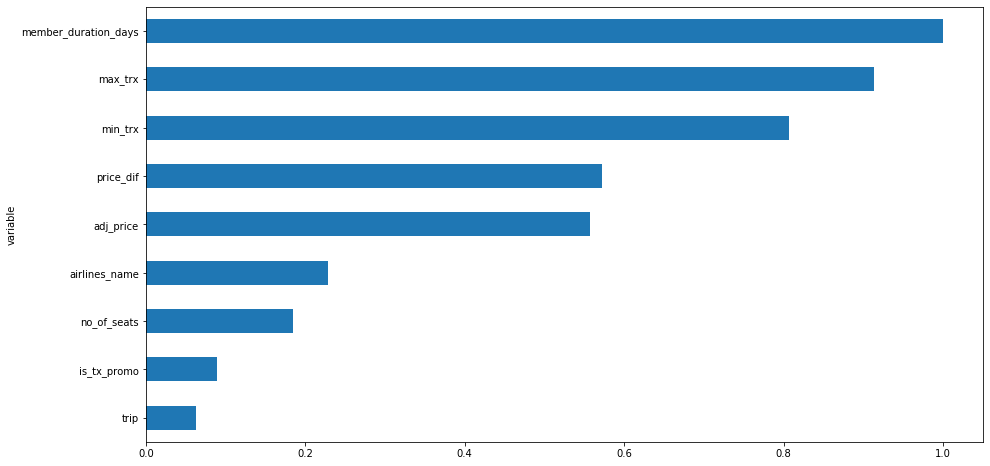

In [0]:
#Variable Importance of Leader Model
m = h2o.get_model(lb[0,"model_id"])
df_imp=m.varimp(use_pandas=True)
df_imp.index=df_imp['variable']

df_imp['scaled_importance'].sort_values().plot.barh(figsize=(15,8))
plt.show()

In [0]:
# XGBoost
params3 = {
      "ntrees" : aml_init.leader.params['ntrees']['actual']
    , "max_depth" : aml_init.leader.params['max_depth']['actual']
    , "keep_cross_validation_predictions" : aml_init.leader.params['keep_cross_validation_predictions']['actual']
    , "nfolds" : aml_init.leader.params['nfolds']['actual']
    , "learn_rate" : aml_init.leader.params['learn_rate']['actual']
    , "sample_rate" : aml_init.leader.params['sample_rate']['actual']
    , "col_sample_rate" :aml_init.leader.params['col_sample_rate']['actual']
    , "col_sample_rate_per_tree" : aml_init.leader.params['col_sample_rate_per_tree']['actual']
    , "min_rows" : aml_init.leader.params['min_rows']['actual']
    , "min_child_weight" :aml_init.leader.params['min_child_weight']['actual']
    , "seed": aml_init.leader.params['seed']['actual']
    , "score_tree_interval": aml_init.leader.params['score_tree_interval']['actual']
    , "subsample" :aml_init.leader.params['subsample']['actual']
    , "max_bins" :aml_init.leader.params['max_bins']['actual']
    , "max_delta_step" :aml_init.leader.params['max_delta_step']['actual']
    , "max_leaves" :aml_init.leader.params['max_leaves']['actual']
    , "booster" :aml_init.leader.params['booster']['actual']
    , "sample_type" :aml_init.leader.params['sample_type']['actual']
    , "stopping_rounds" :aml_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" :aml_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" :aml_init.leader.params['stopping_tolerance']['actual']
    , "nthread" :aml_init.leader.params['nthread']['actual']
    , "eta" :aml_init.leader.params['eta']['actual']
    , "min_split_improvement" :aml_init.leader.params['min_split_improvement']['actual']
    , "reg_lambda" :aml_init.leader.params['reg_lambda']['actual']
    , "reg_alpha" :aml_init.leader.params['reg_alpha']['actual']
}

In [0]:
#gbm
params = {"ntrees" : aml_init.leader.params['ntrees']['actual']
    , "max_depth" : aml_init.leader.params['max_depth']['actual']
    , "nbins" : aml_init.leader.params['nbins']['actual']
    , "nbins_cats" : aml_init.leader.params['nbins_cats']['actual']
    , "learn_rate" : aml_init.leader.params['learn_rate']['actual']
    , "learn_rate_annealing" : aml_init.leader.params['learn_rate_annealing']['actual']
    , "distribution" : aml_init.leader.params['distribution']['actual']
    , "sample_rate" : aml_init.leader.params['sample_rate']['actual']
    , "sample_rate_per_class" : aml_init.leader.params['sample_rate_per_class']['actual']
    , "col_sample_rate" :aml_init.leader.params['col_sample_rate']['actual']
    , "col_sample_rate_change_per_level" : aml_init.leader.params['col_sample_rate_change_per_level']['actual']
    , "col_sample_rate_per_tree" : aml_init.leader.params['col_sample_rate_per_tree']['actual']
    , "min_rows" : aml_init.leader.params['min_rows']['actual']
    , "max_abs_leafnode_pred" : aml_init.leader.params['max_abs_leafnode_pred']['actual']
    , "pred_noise_bandwidth" : aml_init.leader.params['pred_noise_bandwidth']['actual']
    , "categorical_encoding" : aml_init.leader.params['categorical_encoding']['actual']
    # , "min_child_weight" :aml_init.leader.params['min_child_weight']['actual']
    , "seed": aml_init.leader.params['seed']['actual']
    , "score_tree_interval": aml_init.leader.params['score_tree_interval']['actual']
    # , "subsample" :aml_init.leader.params['subsample']['actual']
    # , "max_bins" :aml_init.leader.params['max_bins']['actual']
    # , "max_delta_step" :aml_init.leader.params['max_delta_step']['actual']
    # , "max_leaves" :aml_init.leader.params['max_leaves']['actual']
    # , "booster" :aml_init.leader.params['booster']['actual']
    # , "sample_type" :aml_init.leader.params['sample_type']['actual']
    , "stopping_rounds" :aml_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" :aml_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" :aml_init.leader.params['stopping_tolerance']['actual']
    # , "nthread" :aml_init.leader.params['nthread']['actual']
    # , "eta" :aml_init.leader.params['eta']['actual']
    , "min_split_improvement" :aml_init.leader.params['min_split_improvement']['actual']
    , "histogram_type" : aml_init.leader.params['histogram_type']['actual']
    , "score_each_iteration" : aml_init.leader.params['score_each_iteration']['actual']
    # , "fold_assignment" : aml_init.leader.params['fold_assignment']['actual']
    # , "fold_column" : aml_init.leader.params['fold_column']['actual']
    # , "offset_column" : aml_init.leader.params['offset_column']['actual']
    # , "balance_classes" : aml_init.leader.params['balance_classes']['actual']
    , "max_hit_ratio_k" : aml_init.leader.params['max_hit_ratio_k']['actual']
    , "r2_stopping" : aml_init.leader.params['r2_stopping']['actual']
    , "stopping_rounds" : aml_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" : aml_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" : aml_init.leader.params['max_runtime_secs']['actual']
    , "build_tree_one_node" : aml_init.leader.params['build_tree_one_node']['actual']
    , "quantile_alpha" : aml_init.leader.params['quantile_alpha']['actual']
    , "tweedie_power" : aml_init.leader.params['tweedie_power']['actual']
    , "huber_alpha" : aml_init.leader.params['huber_alpha']['actual']
    , "class_sampling_factors" : aml_init.leader.params['class_sampling_factors']['actual']
    , "max_after_balance_size" : aml_init.leader.params['max_after_balance_size']['actual']
    , "nbins_top_level" : aml_init.leader.params['nbins_top_level']['actual']
    , "calibrate_model" : aml_init.leader.params['calibrate_model']['actual']
    # , "calibration_frame" : aml_init.leader.params['calibration_frame']['actual']
    , "custom_metric_func" : aml_init.leader.params['custom_metric_func']['actual']
    , "custom_distribution_func" : aml_init.leader.params['custom_distribution_func']['actual']
    , "export_checkpoints_dir" : aml_init.leader.params['export_checkpoints_dir']['actual']
    , "monotone_constraints" : aml_init.leader.params['monotone_constraints']['actual']
    , "check_constant_response" : aml_init.leader.params['check_constant_response']['actual']
    # , "reg_lambda" :aml_init.leader.params['reg_lambda']['actual']
    # , "reg?_alpha" :aml_init.leader.params['reg_alpha']['actual']
}

In [0]:
#DRF
params = {"ntrees" : aml_init.leader.params['ntrees']['actual']
    , "max_depth" : aml_init.leader.params['max_depth']['actual']
    , "keep_cross_validation_predictions" : aml_init.leader.params['keep_cross_validation_predictions']['actual']
    , "nfolds" : aml_init.leader.params['nfolds']['actual']
    , "nbins" : aml_init.leader.params['nbins']['actual']
    , "nbins_cats" : aml_init.leader.params['nbins_cats']['actual']    
    , "nbins_top_level" : aml_init.leader.params['nbins_top_level']['actual']
    # , "learn_rate_annealing" : aml_init.leader.params['learn_rate_annealing']['actual']
    , "distribution" : aml_init.leader.params['distribution']['actual']
    , "sample_rate" : aml_init.leader.params['sample_rate']['actual']
    , "sample_rate_per_class" : aml_init.leader.params['sample_rate_per_class']['actual']
    # , "col_sample_rate" :aml_init.leader.params['col_sample_rate']['actual']
    , "col_sample_rate_change_per_level" : aml_init.leader.params['col_sample_rate_change_per_level']['actual']
    , "col_sample_rate_per_tree" : aml_init.leader.params['col_sample_rate_per_tree']['actual']
    , "min_rows" : aml_init.leader.params['min_rows']['actual']
    # , "max_abs_leafnode_pred" : aml_init.leader.params['max_abs_leafnode_pred']['actual']
    # , "pred_noise_bandwidth" : aml_init.leader.params['pred_noise_bandwidth']['actual']
    , "categorical_encoding" : aml_init.leader.params['categorical_encoding']['actual']
    # , "min_child_weight" :aml_init.leader.params['min_child_weight']['actual']
    , "seed": aml_init.leader.params['seed']['actual']
    , "score_tree_interval": aml_init.leader.params['score_tree_interval']['actual']
    # , "subsample" :aml_init.leader.params['subsample']['actual']
    # , "max_bins" :aml_init.leader.params['max_bins']['actual']
    # , "max_delta_step" :aml_init.leader.params['max_delta_step']['actual']
    # , "max_leaves" :aml_init.leader.params['max_leaves']['actual']
    # , "booster" :aml_init.leader.params['booster']['actual']
    # , "sample_type" :aml_init.leader.params['sample_type']['actual']
    , "stopping_rounds" :aml_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" :aml_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" :aml_init.leader.params['stopping_tolerance']['actual']
    # , "nthread" :aml_init.leader.params['nthread']['actual']
    # , "eta" :aml_init.leader.params['eta']['actual']
    , "min_split_improvement" :aml_init.leader.params['min_split_improvement']['actual']
    , "histogram_type" : aml_init.leader.params['histogram_type']['actual']
    , "score_each_iteration" : aml_init.leader.params['score_each_iteration']['actual']
    # , "fold_assignment" : aml_init.leader.params['fold_assignment']['actual']
    # , "fold_column" : aml_init.leader.params['fold_column']['actual']
    # , "offset_column" : aml_init.leader.params['offset_column']['actual']
    , "max_runtime_secs" : aml_init.leader.params['max_runtime_secs']['actual']
    , "max_hit_ratio_k" : aml_init.leader.params['max_hit_ratio_k']['actual']
    , "r2_stopping" : aml_init.leader.params['r2_stopping']['actual']
    , "stopping_rounds" : aml_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" : aml_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" : aml_init.leader.params['max_runtime_secs']['actual']
    , "build_tree_one_node" : aml_init.leader.params['build_tree_one_node']['actual']
    , "binomial_double_trees" : aml_init.leader.params['binomial_double_trees']['actual']
    # , "tweedie_power" : aml_init.leader.params['tweedie_power']['actual']
    # , "huber_alpha" : aml_init.leader.params['huber_alpha']['actual']
    , "class_sampling_factors" : aml_init.leader.params['class_sampling_factors']['actual']
    , "max_after_balance_size" : aml_init.leader.params['max_after_balance_size']['actual']
    , "nbins_top_level" : aml_init.leader.params['nbins_top_level']['actual']
    , "calibrate_model" : aml_init.leader.params['calibrate_model']['actual']
    , "mtries" : aml_init.leader.params['mtries']['actual']
    , "custom_metric_func" : aml_init.leader.params['custom_metric_func']['actual']
    # , "custom_distribution_func" : aml_init.leader.params['custom_distribution_func']['actual']
    , "export_checkpoints_dir" : aml_init.leader.params['export_checkpoints_dir']['actual']
    # , "monotone_constraints" : aml_init.leader.params['monotone_constraints']['actual']
    , "check_constant_response" : aml_init.leader.params['check_constant_response']['actual']
    # , "reg_lambda" :aml_init.leader.params['reg_lambda']['actual']
    # , "reg?_alpha" :aml_init.leader.params['reg_alpha']['actual']
}

In [0]:
#GLM
params = {"family" : aml_init.leader.params['family']['actual']
    , "rand_family" : aml_init.leader.params['rand_family']['actual']
    , "tweedie_variance_power" : aml_init.leader.params['tweedie_variance_power']['actual']
    , "tweedie_link_power" : aml_init.leader.params['tweedie_link_power']['actual']    
    , "theta" : aml_init.leader.params['theta']['actual']
    # , "learn_rate_annealing" : aml_init.leader.params['learn_rate_annealing']['actual']
    , "solver" : aml_init.leader.params['solver']['actual']
    , "alpha" : aml_init.leader.params['alpha']['actual']
    # , "lambda" : aml_init.leader.params['lambda']['actual']
    # , "col_sample_rate" :aml_init.leader.params['col_sample_rate']['actual']
    # , "lambda_search" : aml_init.leader.params['lambda_search']['actual']
    , "early_stopping" : aml_init.leader.params['early_stopping']['actual']
    , "nlambdas" : aml_init.leader.params['nlambdas']['actual']
    # , "max_abs_leafnode_pred" : aml_init.leader.params['max_abs_leafnode_pred']['actual']
    # , "pred_noise_bandwidth" : aml_init.leader.params['pred_noise_bandwidth']['actual']
    , "standardize" : aml_init.leader.params['standardize']['actual']
    # , "min_child_weight" :aml_init.leader.params['min_child_weight']['actual']
    , "missing_values_handling": aml_init.leader.params['missing_values_handling']['actual']
    , "plug_values": aml_init.leader.params['plug_values']['actual']
    # , "subsample" :aml_init.leader.params['subsample']['actual']
    # , "max_bins" :aml_init.leader.params['max_bins']['actual']
    # , "max_delta_step" :aml_init.leader.params['max_delta_step']['actual']
    # , "max_leaves" :aml_init.leader.params['max_leaves']['actual']
    # , "booster" :aml_init.leader.params['booster']['actual']
    # , "sample_type" :aml_init.leader.params['sample_type']['actual']
    , "compute_p_values" :aml_init.leader.params['compute_p_values']['actual']
    , "remove_collinear_columns" :aml_init.leader.params['remove_collinear_columns']['actual']
    , "intercept" :aml_init.leader.params['intercept']['actual']
    # , "nthread" :aml_init.leader.params['nthread']['actual']
    # , "eta" :aml_init.leader.params['eta']['actual']
    , "non_negative" :aml_init.leader.params['non_negative']['actual']
    , "max_iterations" : aml_init.leader.params['max_iterations']['actual']
    , "objective_epsilon" : aml_init.leader.params['objective_epsilon']['actual']
    # , "fold_assignment" : aml_init.leader.params['fold_assignment']['actual']
    # , "fold_column" : aml_init.leader.params['fold_column']['actual']
    # , "offset_column" : aml_init.leader.params['offset_column']['actual']
    , "beta_epsilon" : aml_init.leader.params['beta_epsilon']['actual']
    , "gradient_epsilon" : aml_init.leader.params['gradient_epsilon']['actual']
    , "link" : aml_init.leader.params['link']['actual']
    , "rand_link" : aml_init.leader.params['rand_link']['actual']
    , "startval" : aml_init.leader.params['startval']['actual']
    , "calc_like" : aml_init.leader.params['calc_like']['actual']
    # , "hglm" : aml_init.leader.params['hglm']['actual']
    , "prior" : aml_init.leader.params['prior']['actual']
    # , "tweedie_power" : aml_init.leader.params['tweedie_power']['actual']
    # , "huber_alpha" : aml_init.leader.params['huber_alpha']['actual']
    # , "lambda_min_ratio" : aml_init.leader.params['lambda_min_ratio']['actual']
    , "beta_constraints" : aml_init.leader.params['beta_constraints']['actual']
    , "max_active_predictors" : aml_init.leader.params['max_active_predictors']['actual']
    , "interactions" : aml_init.leader.params['interactions']['actual']
    , "interaction_pairs" : aml_init.leader.params['interaction_pairs']['actual']
    , "obj_reg" : aml_init.leader.params['obj_reg']['actual']
    # , "custom_distribution_func" : aml_init.leader.params['custom_distribution_func']['actual']
    # , "custom_metric_func" : aml_init.leader.params['custom_metric_func']['actual']
    # , "monotone_constraints" : aml_init.leader.params['monotone_constraints']['actual']
    # , "upload_custom_metric" : aml_init.leader.params['upload_checkpoints_dir']['actual']
    # , "reg_lambda" :aml_init.leader.params['reg_lambda']['actual']
    # , "reg?_alpha" :aml_init.leader.params['reg_alpha']['actual']
}

### MODEL 2

In [0]:
#Initialize H2O
h2o.init()

# drop_columns=['trip','no_of_seats', 'visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado','gender','service_class','is_tx_promo','airlines_name', 'is_refund']
drop_columns=['service_class','gender','price','is_refund','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado']
drop_columns.append('account_id')

#convert to H2OFrame
df_h2o = h2o.H2OFrame(df.drop(drop_columns,1))

#specify the target and predictor variable
except_target=drop_columns.copy()
except_target.append('is_cross_sell')
x=df.drop(except_target,1).columns.tolist()
y='is_cross_sell'

#using automl with XGBoost Model to help find the best parameter
aml2_init = H2OAutoML(max_runtime_secs=3000, balance_classes=False,seed = 1,nfolds=5,stopping_rounds=5,
               sort_metric='logloss',include_algos=['GBM'])
aml2_init.train(x = x, y = y, training_frame = df_h2o)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,3 hours 4 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,11 days
H2O cluster name:,H2O_from_python_unknownUser_ovws13
H2O cluster total nodes:,1
H2O cluster free memory:,4.724 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |███████████████████████████████████████████████████████

In [0]:
#Leaderboard
lb2=aml2_init.leaderboard
print(lb)

In [0]:
#Variable Importance of Leader Model
m2 = h2o.get_model(lb2[0,"model_id"])
df_imp2=m2.varimp(use_pandas=True)
df_imp2.index=df_imp2['variable']

df_imp2['scaled_importance'].sort_values().plot.barh(figsize=(15,8))
plt.show()

In [0]:
#gbm
params2 = {"ntrees" : aml2_init.leader.params['ntrees']['actual']
    , "max_depth" : aml2_init.leader.params['max_depth']['actual']
    , "keep_cross_validation_predictions" : aml2_init.leader.params['keep_cross_validation_predictions']['actual']
    , "nfolds" : aml2_init.leader.params['nfolds']['actual']
    , "nbins" : aml2_init.leader.params['nbins']['actual']
    , "nbins_cats" : aml2_init.leader.params['nbins_cats']['actual']
    , "learn_rate" : aml2_init.leader.params['learn_rate']['actual']
    , "learn_rate_annealing" : aml2_init.leader.params['learn_rate_annealing']['actual']
    , "distribution" : aml2_init.leader.params['distribution']['actual']
    , "sample_rate" : aml2_init.leader.params['sample_rate']['actual']
    , "sample_rate_per_class" : aml2_init.leader.params['sample_rate_per_class']['actual']
    , "col_sample_rate" :aml2_init.leader.params['col_sample_rate']['actual']
    , "col_sample_rate_change_per_level" : aml2_init.leader.params['col_sample_rate_change_per_level']['actual']
    , "col_sample_rate_per_tree" : aml2_init.leader.params['col_sample_rate_per_tree']['actual']
    , "min_rows" : aml2_init.leader.params['min_rows']['actual']
    , "max_abs_leafnode_pred" : aml2_init.leader.params['max_abs_leafnode_pred']['actual']
    , "pred_noise_bandwidth" : aml2_init.leader.params['pred_noise_bandwidth']['actual']
    , "categorical_encoding" : aml2_init.leader.params['categorical_encoding']['actual']
    # , "min_child_weight" :aml_init.leader.params['min_child_weight']['actual']
    , "seed": aml2_init.leader.params['seed']['actual']
    , "score_tree_interval": aml2_init.leader.params['score_tree_interval']['actual']
    # , "subsample" :aml_init.leader.params['subsample']['actual']
    # , "max_bins" :aml_init.leader.params['max_bins']['actual']
    # , "max_delta_step" :aml_init.leader.params['max_delta_step']['actual']
    # , "max_leaves" :aml_init.leader.params['max_leaves']['actual']
    # , "booster" :aml_init.leader.params['booster']['actual']
    # , "sample_type" :aml_init.leader.params['sample_type']['actual']
    , "stopping_rounds" :aml2_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" :aml2_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" :aml2_init.leader.params['stopping_tolerance']['actual']
    # , "nthread" :aml_init.leader.params['nthread']['actual']
    # , "eta" :aml_init.leader.params['eta']['actual']
    , "min_split_improvement" :aml2_init.leader.params['min_split_improvement']['actual']
    , "histogram_type" : aml2_init.leader.params['histogram_type']['actual']
    , "score_each_iteration" : aml2_init.leader.params['score_each_iteration']['actual']
    # , "fold_assignment" : aml_init.leader.params['fold_assignment']['actual']
    # , "fold_column" : aml_init.leader.params['fold_column']['actual']
    # , "offset_column" : aml_init.leader.params['offset_column']['actual']
    # , "balance_classes" : aml_init.leader.params['balance_classes']['actual']
    , "max_hit_ratio_k" : aml2_init.leader.params['max_hit_ratio_k']['actual']
    , "r2_stopping" : aml2_init.leader.params['r2_stopping']['actual']
    , "stopping_rounds" : aml2_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" : aml2_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" : aml2_init.leader.params['max_runtime_secs']['actual']
    , "build_tree_one_node" : aml2_init.leader.params['build_tree_one_node']['actual']
    , "quantile_alpha" : aml2_init.leader.params['quantile_alpha']['actual']
    , "tweedie_power" : aml2_init.leader.params['tweedie_power']['actual']
    , "huber_alpha" : aml2_init.leader.params['huber_alpha']['actual']
    , "class_sampling_factors" : aml2_init.leader.params['class_sampling_factors']['actual']
    , "max_after_balance_size" : aml2_init.leader.params['max_after_balance_size']['actual']
    , "nbins_top_level" : aml2_init.leader.params['nbins_top_level']['actual']
    , "calibrate_model" : aml2_init.leader.params['calibrate_model']['actual']
    # , "calibration_frame" : aml_init.leader.params['calibration_frame']['actual']
    , "custom_metric_func" : aml2_init.leader.params['custom_metric_func']['actual']
    , "custom_distribution_func" : aml2_init.leader.params['custom_distribution_func']['actual']
    , "export_checkpoints_dir" : aml2_init.leader.params['export_checkpoints_dir']['actual']
    , "monotone_constraints" : aml2_init.leader.params['monotone_constraints']['actual']
    , "check_constant_response" : aml2_init.leader.params['check_constant_response']['actual']
    # , "reg_lambda" :aml_init.leader.params['reg_lambda']['actual']
    # , "reg?_alpha" :aml_init.leader.params['reg_alpha']['actual']
}

In [0]:
# XGBoost
params2 = {
      "ntrees" : aml2_init.leader.params['ntrees']['actual']
    , "max_depth" : aml2_init.leader.params['max_depth']['actual']
    , "nfolds" : aml2_init.leader.params['nfolds']['actual']
    , "keep_cross_validation_predictions" : aml2_init.leader.params['keep_cross_validation_predictions']['actual']
    , "learn_rate" : aml2_init.leader.params['learn_rate']['actual']
    , "sample_rate" : aml2_init.leader.params['sample_rate']['actual']
    , "col_sample_rate" :aml2_init.leader.params['col_sample_rate']['actual']
    , "col_sample_rate_per_tree" : aml2_init.leader.params['col_sample_rate_per_tree']['actual']
    , "min_rows" : aml2_init.leader.params['min_rows']['actual']
    , "min_child_weight" :aml2_init.leader.params['min_child_weight']['actual']
    , "seed": aml2_init.leader.params['seed']['actual']
    , "score_tree_interval": aml2_init.leader.params['score_tree_interval']['actual']
    , "subsample" :aml2_init.leader.params['subsample']['actual']
    , "max_bins" :aml2_init.leader.params['max_bins']['actual']
    , "max_delta_step" :aml2_init.leader.params['max_delta_step']['actual']
    , "max_leaves" :aml2_init.leader.params['max_leaves']['actual']
    , "booster" :aml2_init.leader.params['booster']['actual']
    , "sample_type" :aml2_init.leader.params['sample_type']['actual']
    , "stopping_rounds" :aml2_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" :aml2_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" :aml2_init.leader.params['stopping_tolerance']['actual']
    , "nthread" :aml2_init.leader.params['nthread']['actual']
    , "eta" :aml2_init.leader.params['eta']['actual']
    , "min_split_improvement" :aml2_init.leader.params['min_split_improvement']['actual']
    , "reg_lambda" :aml2_init.leader.params['reg_lambda']['actual']
    , "reg_alpha" :aml2_init.leader.params['reg_alpha']['actual']
}

In [0]:
#GLM
params2 = {"family" : aml2_init.leader.params['family']['actual']
    , "rand_family" : aml2_init.leader.params['rand_family']['actual']
    , "tweedie_variance_power" : aml2_init.leader.params['tweedie_variance_power']['actual']
    , "nfolds" : aml2_init.leader.params['nfolds']['actual']
    , "keep_cross_validation_predictions" : aml2_init.leader.params['keep_cross_validation_predictions']['actual']
    , "tweedie_link_power" : aml2_init.leader.params['tweedie_link_power']['actual']    
    , "theta" : aml2_init.leader.params['theta']['actual']
    , "seed": aml2_init.leader.params['seed']['actual']
    # , "learn_rate_annealing" : aml_init.leader.params['learn_rate_annealing']['actual']
    , "solver" : aml2_init.leader.params['solver']['actual']
    , "alpha" : aml2_init.leader.params['alpha']['actual']
    # , "lambda" : aml_init.leader.params['lambda']['actual']
    # , "col_sample_rate" :aml_init.leader.params['col_sample_rate']['actual']
    # , "lambda_search" : aml_init.leader.params['lambda_search']['actual']
    , "early_stopping" : aml2_init.leader.params['early_stopping']['actual']
    , "nlambdas" : aml2_init.leader.params['nlambdas']['actual']
    # , "max_abs_leafnode_pred" : aml_init.leader.params['max_abs_leafnode_pred']['actual']
    # , "pred_noise_bandwidth" : aml_init.leader.params['pred_noise_bandwidth']['actual']
    , "standardize" : aml2_init.leader.params['standardize']['actual']
    # , "min_child_weight" :aml_init.leader.params['min_child_weight']['actual']
    , "missing_values_handling": aml2_init.leader.params['missing_values_handling']['actual']
    , "plug_values": aml2_init.leader.params['plug_values']['actual']
    # , "subsample" :aml_init.leader.params['subsample']['actual']
    # , "max_bins" :aml_init.leader.params['max_bins']['actual']
    # , "max_delta_step" :aml_init.leader.params['max_delta_step']['actual']
    # , "max_leaves" :aml_init.leader.params['max_leaves']['actual']
    # , "booster" :aml_init.leader.params['booster']['actual']
    # , "sample_type" :aml_init.leader.params['sample_type']['actual']
    , "compute_p_values" :aml2_init.leader.params['compute_p_values']['actual']
    , "remove_collinear_columns" :aml2_init.leader.params['remove_collinear_columns']['actual']
    , "intercept" :aml2_init.leader.params['intercept']['actual']
    # , "nthread" :aml_init.leader.params['nthread']['actual']
    # , "eta" :aml_init.leader.params['eta']['actual']
    , "non_negative" :aml2_init.leader.params['non_negative']['actual']
    , "max_iterations" : aml2_init.leader.params['max_iterations']['actual']
    , "objective_epsilon" : aml2_init.leader.params['objective_epsilon']['actual']
    # , "fold_assignment" : aml_init.leader.params['fold_assignment']['actual']
    # , "fold_column" : aml_init.leader.params['fold_column']['actual']
    # , "offset_column" : aml_init.leader.params['offset_column']['actual']
    , "beta_epsilon" : aml2_init.leader.params['beta_epsilon']['actual']
    , "gradient_epsilon" : aml2_init.leader.params['gradient_epsilon']['actual']
    , "link" : aml2_init.leader.params['link']['actual']
    , "rand_link" : aml2_init.leader.params['rand_link']['actual']
    , "startval" : aml2_init.leader.params['startval']['actual']
    , "calc_like" : aml2_init.leader.params['calc_like']['actual']
    # , "hglm" : aml_init.leader.params['hglm']['actual']
    , "prior" : aml2_init.leader.params['prior']['actual']
    # , "tweedie_power" : aml_init.leader.params['tweedie_power']['actual']
    # , "huber_alpha" : aml_init.leader.params['huber_alpha']['actual']
    # , "lambda_min_ratio" : aml_init.leader.params['lambda_min_ratio']['actual']
    , "beta_constraints" : aml2_init.leader.params['beta_constraints']['actual']
    , "max_active_predictors" : aml2_init.leader.params['max_active_predictors']['actual']
    , "interactions" : aml2_init.leader.params['interactions']['actual']
    , "interaction_pairs" : aml2_init.leader.params['interaction_pairs']['actual']
    , "obj_reg" : aml2_init.leader.params['obj_reg']['actual']
    # , "custom_distribution_func" : aml_init.leader.params['custom_distribution_func']['actual']
    # , "custom_metric_func" : aml_init.leader.params['custom_metric_func']['actual']
    # , "monotone_constraints" : aml_init.leader.params['monotone_constraints']['actual']
    # , "upload_custom_metric" : aml_init.leader.params['upload_checkpoints_dir']['actual']
    # , "reg_lambda" :aml_init.leader.params['reg_lambda']['actual']
    # , "reg?_alpha" :aml_init.leader.params['reg_alpha']['actual']
}

In [0]:
params2

In [0]:
params2['seed'] = params['seed']

In [0]:
params3['seed'] = params['seed']

### XGBoost

In [0]:
#darivinson
def cross_val_xgboost(df,drop_columns,f1_threshold,params,nfolds,is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=True,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False):
  f1_list=[]
  #Initiate StratifiedKFold Class
  kfold = KFold(n_splits=nfolds, shuffle=True, random_state=500)
  #Drop Columns
  if len(drop_columns)>0:
    df=df.drop(drop_columns,1)
  #begin looping
  for train,val in kfold.split(df):
    print("mohon bersabar")
    df_train=df.loc[train,:]
    df_val=df.loc[val,:]

    #Feature Engineering
    if is_feat_eng:
      if label_not_cross_sell:
        #Creating list of customer which has number of orders more than 50
        acc=pd.DataFrame(df_train['account_id'].value_counts())
        top_acc_list=acc[acc.account_id>50].index.tolist()
        #Creating list of customer which never done cross selling
        toy=df_train.copy()
        toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
        cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
        no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
        #Creating  list of customer which has number of orders more than 50 and never done cross selling
        not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

        df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
        df_val['label_not_cross_sell']=df_val['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      if is_segment:
        df_train,df_val=segmentation(df_train,df_val,k=4)
      if is_WoE:
        df_train,df_val=WoE(df_train,df_val,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
      if is_mean_encode:
        df_train,df_val=mean_encoding(df_train,df_val,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_mean)
      if is_binning:
        df_train,df_val=detailed_segmentation(df_train,df_val,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
      if 'account_id' in df_train.columns:
        df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)
      print('Done Feature Engineering!')
    else:
      df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)

    df_train_h2o = h2o.H2OFrame(df_train)
    df_val_h2o = h2o.H2OFrame(df_val)
    #specify the target and predictor variable
    x=df_train.drop('is_cross_sell',1).columns.tolist()
    y='is_cross_sell'

    #Initiate Model
    model_xgboost = H2OXGBoostEstimator(**params)
    model_xgboost.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    prediction = model_xgboost.predict(df_val_h2o)[:,2]
    prediction_prob=prediction.as_data_frame()['Yes']
    for k in f1_threshold :
        prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
        # calculate the new F1
        precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
        recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
        f1=2*precision*recall/(precision+recall)
        print('Threshold : {}, F1 Score: {}'.format(k,f1))
        f1_list.append(f1)
  return f1_list

coba_threshold = np.arange(0,0.45,0.005)
hasil = cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=coba_threshold,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False)

hasil_xgboost = pd.DataFrame(np.array(hasil).reshape(5,len(coba_threshold)).transpose())
hasil_xgboost.index = coba_threshold
hasil_xgboost['mean'] = hasil_xgboost.mean(axis=1)
hasil_xgboost
hasil_xgboost.sort_values(by='mean',ascending=False)

mohon bersabar
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
Threshold : 0.0, F1 Score: 0.11090969017798287
Threshold : 0.005, F1 Score: 0.1560829312817838
Threshold : 0.01, F1 Score: 0.15592379958246347
Threshold : 0.015, F1 Score: 0.15598485837358048
Threshold : 0.02, F1 Score: 0.15619894124567024
Threshold : 0.025, F1 Score: 0.15624383507595188
Threshold : 0.03, F1 Score: 0.15791599353796446
Threshold : 0.035, F1 Score: 0.16045967227069588
Threshold : 0.04, F1 Score: 0.16915734293091308
Threshold : 0.045, F1 Score: 0.18186738836265223
Threshold : 0.05, F1 Score: 0.199292073366942
Threshold : 0.055, F1 Score: 0.21858349577647826
Threshold : 0.06, F1 Score: 0.24429187290435894
Threshold

,0,1,2,3,4,mean
0.235,0.427599,0.412799,0.417273,0.424627,0.427580,0.421975
0.230,0.427536,0.411316,0.418478,0.423859,0.427516,0.421741
0.225,0.427088,0.410578,0.418248,0.422523,0.428900,0.421467
0.220,0.427350,0.410371,0.416554,0.421384,0.430797,0.421291
0.240,0.425455,0.411738,0.417693,0.425455,0.425986,0.421265
...,...,...,...,...,...,...
0.020,0.156199,0.163812,0.172917,0.182333,0.156089,0.166270
0.015,0.155985,0.157503,0.161136,0.161640,0.151854,0.157624
0.010,0.155924,0.156704,0.156545,0.157426,0.151174,0.155554
0.005,0.156083,0.156674,0.156438,0.157261,0.151144,0.155520


### GBM


In [0]:
#darivinson GBM
def cross_val_gbm(df,drop_columns,f1_threshold,params,nfolds,is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=True,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False):
  f1_list=[]
  #Initiate StratifiedKFold Class
  kfold = KFold(n_splits=nfolds, shuffle=True, random_state=500)
  #Drop Columns
  if len(drop_columns)>0:
    df=df.drop(drop_columns,1)
  #begin looping
  for train,val in kfold.split(df):
    print("mohon bersabar")
    df_train=df.loc[train,:]
    df_val=df.loc[val,:]

    #Feature Engineering
    if is_feat_eng:
      if label_not_cross_sell:
        #Creating list of customer which has number of orders more than 50
        acc=pd.DataFrame(df_train['account_id'].value_counts())
        top_acc_list=acc[acc.account_id>50].index.tolist()
        #Creating list of customer which never done cross selling
        toy=df_train.copy()
        toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
        cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
        no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
        #Creating  list of customer which has number of orders more than 50 and never done cross selling
        not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

        df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
        df_val['label_not_cross_sell']=df_val['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      if is_segment:
        df_train,df_val=segmentation(df_train,df_val,k=4)
      if is_WoE:
        df_train,df_val=WoE(df_train,df_val,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
      if is_mean_encode:
        df_train,df_val=mean_encoding(df_train,df_val,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_mean)
      if is_binning:
        df_train,df_val=detailed_segmentation(df_train,df_val,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
      if 'account_id' in df_train.columns:
        df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)
      print('Done Feature Engineering!')
    else:
      df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)

    df_train_h2o = h2o.H2OFrame(df_train)
    df_val_h2o = h2o.H2OFrame(df_val)
    #specify the target and predictor variable
    x=df_train.drop('is_cross_sell',1).columns.tolist()
    y='is_cross_sell'

    #Initiate Model
    # model_GBM = H2OXGBoostEstimator(**params)
    model_gbm = H2OGradientBoostingEstimator(**params)
    model_gbm.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    prediction = model_gbm.predict(df_val_h2o)[:,2]
    prediction_prob=prediction.as_data_frame()['Yes']
    for k in f1_threshold :
        prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
        # calculate the new F1
        precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
        recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
        f1=2*precision*recall/(precision+recall)
        print('Threshold : {}, F1 Score: {}'.format(k,f1))
        f1_list.append(f1)
  return f1_list

coba_threshold = np.arange(0,0.45,0.005)
hasil = cross_val_gbm(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=coba_threshold,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False)

hasil_gbm = pd.DataFrame(np.array(hasil).reshape(5,len(coba_threshold)).transpose())
hasil_gbm.index = coba_threshold
hasil_gbm['mean'] = hasil_gbm.mean(axis=1)
hasil_gbm
hasil_gbm.sort_values(by='mean',ascending=False)

mohon bersabar
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Threshold : 0.0, F1 Score: 0.11090969017798287
Threshold : 0.005, F1 Score: 0.15656499541824845
Threshold : 0.01, F1 Score: 0.16020457529891488
Threshold : 0.015, F1 Score: 0.17283560887064953
Threshold : 0.02, F1 Score: 0.18552036199095023
Threshold : 0.025, F1 Score: 0.19917440660474717
Threshold : 0.03, F1 Score: 0.21353313041442284
Threshold : 0.035, F1 Score: 0.2287989382879894
Threshold : 0.04, F1 Score: 0.24372652141247184
Threshold : 0.045, F1 Score: 0.259805564867583
Threshold : 0.05, F1 Score: 0.2749063670411985
Threshold : 0.055, F1 Score: 0.28630193336075693
Threshold : 0.06, F1 Score: 0.3024871162894914
Threshold :

,0,1,2,3,4,mean
0.260,0.426863,0.412511,0.415335,0.421882,0.414211,0.418161
0.265,0.425806,0.411096,0.414456,0.422326,0.415902,0.417917
0.295,0.425891,0.409217,0.412150,0.419811,0.422253,0.417864
0.285,0.425909,0.408987,0.415584,0.419718,0.418500,0.417740
0.270,0.424942,0.410560,0.414332,0.420905,0.417254,0.417599
...,...,...,...,...,...,...
0.020,0.185520,0.220081,0.212506,0.183871,0.163296,0.193055
0.015,0.172836,0.197640,0.199878,0.171593,0.156202,0.179630
0.010,0.160205,0.173953,0.184790,0.162782,0.152755,0.166897
0.005,0.156565,0.158867,0.163877,0.158256,0.151503,0.157814


### DRF

In [0]:
#darivinson drf  
def cross_val_drf(df,drop_columns,f1_threshold,params,nfolds,is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False):
  f1_list=[]
  #Initiate StratifiedKFold Class
  kfold = KFold(n_splits=nfolds, shuffle=True, random_state=500)
  #Drop Columns
  if len(drop_columns)>0:
    df=df.drop(drop_columns,1)
  #begin looping
  for train,val in kfold.split(df):
    print("mohon bersabar")
    df_train=df.loc[train,:]
    df_val=df.loc[val,:]

    #Feature Engineering
    if is_feat_eng:
      if label_not_cross_sell:
        #Creating list of customer which has number of orders more than 50
        acc=pd.DataFrame(df_train['account_id'].value_counts())
        top_acc_list=acc[acc.account_id>50].index.tolist()
        #Creating list of customer which never done cross selling
        toy=df_train.copy()
        toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
        cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
        no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
        #Creating  list of customer which has number of orders more than 50 and never done cross selling
        not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

        df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
        df_val['label_not_cross_sell']=df_val['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      if is_segment:
        df_train,df_val=segmentation(df_train,df_val,k=4)
      if is_WoE:
        df_train,df_val=WoE(df_train,df_val,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
      if is_mean_encode:
        df_train,df_val=mean_encoding(df_train,df_val,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_mean)
      if is_binning:
        df_train,df_val=detailed_segmentation(df_train,df_val,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
      if 'account_id' in df_train.columns:
        df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)
      print('Done Feature Engineering!')
    else:
      df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)

    df_train_h2o = h2o.H2OFrame(df_train)
    df_val_h2o = h2o.H2OFrame(df_val)
    #specify the target and predictor variable
    x=df_train.drop('is_cross_sell',1).columns.tolist()
    y='is_cross_sell'

    #Initiate Model
    # model_GBM = H2OXGBoostEstimator(**params)
    model_drf = H2ORandomForestEstimator(**params)
    model_drf.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    prediction = model_drf.predict(df_val_h2o)[:,2]
    prediction_prob=prediction.as_data_frame()['Yes']
    for k in f1_threshold :
        prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
        # calculate the new F1
        precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
        recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
        f1=2*precision*recall/(precision+recall)
        print('Threshold : {}, F1 Score: {}'.format(k,f1))
        f1_list.append(f1)
  return f1_list

coba_threshold = np.arange(0,0.45,0.005)
hasil = cross_val_drf(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=coba_threshold,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False)

hasil_drf = pd.DataFrame(np.array(hasil).reshape(5,len(coba_threshold)).transpose())
hasil_drf.index = coba_threshold
hasil_drf['mean'] = hasil_drf.mean(axis=1)
hasil_drf
hasil_drf.sort_values(by='mean',ascending=False)

mohon bersabar
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Threshold : 0.0, F1 Score: 0.13301922971566318
Threshold : 0.005, F1 Score: 0.164619532654284
Threshold : 0.01, F1 Score: 0.166123531640773
Threshold : 0.015, F1 Score: 0.16801745635910226
Threshold : 0.02, F1 Score: 0.16852966466036112
Threshold : 0.025, F1 Score: 0.19446233097231166
Threshold : 0.03, F1 Score: 0.1953031130529765
Threshold : 0.035, F1 Score: 0.19822686974312348
Threshold : 0.04, F1 Score: 0.19928825622775798
Threshold : 0.045, F1 Score: 0.23055555555555557
Threshold : 0.05, F1 Score: 0.23527539000318368
Threshold : 0.055, F1 Score: 0.24199528142905294
Threshold : 0.06, F1 Score: 0.24334992277329673
Threshold :

,0,1,2,3,4,mean
0.230,0.433692,0.414945,0.420959,0.428061,0.433318,0.426195
0.235,0.431971,0.413945,0.419742,0.429019,0.434307,0.425797
0.240,0.431213,0.413976,0.421100,0.426259,0.435101,0.425530
0.225,0.433735,0.414367,0.419469,0.426346,0.433560,0.425495
0.310,0.432180,0.413004,0.420613,0.431115,0.429389,0.425260
...,...,...,...,...,...,...
0.020,0.168530,0.173992,0.168300,0.166982,0.160514,0.167664
0.015,0.168017,0.173856,0.168323,0.167077,0.160525,0.167560
0.010,0.166124,0.173091,0.167747,0.167128,0.159094,0.166637
0.005,0.164620,0.170447,0.166395,0.165298,0.157323,0.164817


In [0]:
# is_woe=true
#darivinson drf
def cross_val_drf(df,drop_columns,f1_threshold,params,nfolds,is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False):
  f1_list=[]
  #Initiate StratifiedKFold Class
  kfold = KFold(n_splits=nfolds, shuffle=True, random_state=500)
  #Drop Columns
  if len(drop_columns)>0:
    df=df.drop(drop_columns,1)
  #begin looping
  for train,val in kfold.split(df):
    print("mohon bersabar")
    df_train=df.loc[train,:]
    df_val=df.loc[val,:]

    #Feature Engineering
    if is_feat_eng:
      if label_not_cross_sell:
        #Creating list of customer which has number of orders more than 50
        acc=pd.DataFrame(df_train['account_id'].value_counts())
        top_acc_list=acc[acc.account_id>50].index.tolist()
        #Creating list of customer which never done cross selling
        toy=df_train.copy()
        toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
        cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
        no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
        #Creating  list of customer which has number of orders more than 50 and never done cross selling
        not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

        df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
        df_val['label_not_cross_sell']=df_val['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      if is_segment:
        df_train,df_val=segmentation(df_train,df_val,k=4)
      if is_WoE:
        df_train,df_val=WoE(df_train,df_val,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
      if is_mean_encode:
        df_train,df_val=mean_encoding(df_train,df_val,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_mean)
      if is_binning:
        df_train,df_val=detailed_segmentation(df_train,df_val,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
      if 'account_id' in df_train.columns:
        df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)
      print('Done Feature Engineering!')
    else:
      df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)

    df_train_h2o = h2o.H2OFrame(df_train)
    df_val_h2o = h2o.H2OFrame(df_val)
    #specify the target and predictor variable
    x=df_train.drop('is_cross_sell',1).columns.tolist()
    y='is_cross_sell'

    #Initiate Model
    # model_GBM = H2OXGBoostEstimator(**params)
    model_drf = H2ORandomForestEstimator(**params)
    model_drf.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    prediction = model_drf.predict(df_val_h2o)[:,2]
    prediction_prob=prediction.as_data_frame()['Yes']
    for k in f1_threshold :
        prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
        # calculate the new F1
        precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
        recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
        f1=2*precision*recall/(precision+recall)
        print('Threshold : {}, F1 Score: {}'.format(k,f1))
        f1_list.append(f1)
  return f1_list

coba_threshold = np.arange(0,0.45,0.005)
hasil = cross_val_drf(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=coba_threshold,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False)

hasil_drf = pd.DataFrame(np.array(hasil).reshape(5,len(coba_threshold)).transpose())
hasil_drf.index = coba_threshold
hasil_drf['mean'] = hasil_drf.mean(axis=1)
hasil_drf
hasil_drf.sort_values(by='mean',ascending=False)

mohon bersabar
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Threshold : 0.0, F1 Score: 0.15131233595800525
Threshold : 0.005, F1 Score: 0.16373148625746076
Threshold : 0.01, F1 Score: 0.16428412710169618
Threshold : 0.015, F1 Score: 0.16562832396292357
Threshold : 0.02, F1 Score: 0.1655256351741975
Threshold : 0.025, F1 Score: 0.19448810646547207
Threshold : 0.03, F1 Score: 0.19502908514013748
Threshold : 0.035, F1 Score: 0.19859442303332575
Threshold : 0.04, F1 Score: 0.19906510090069546
Threshold : 0.045, F1 Score: 0.2364237368172517
Threshold : 0.05, F1 Score: 0.2378671775223499
Threshold : 0.055, F1 Score: 0.24944013781223082
Threshold : 0.06, F1 Score: 0.25043357613596945
Threshold

,0,1,2,3,4,mean
0.260,0.437158,0.414196,0.421053,0.426824,0.432634,0.426373
0.255,0.436677,0.412897,0.422383,0.427343,0.432483,0.426357
0.265,0.437243,0.414041,0.420000,0.427793,0.431978,0.426211
0.320,0.438588,0.414431,0.420412,0.427837,0.428503,0.425954
0.250,0.435688,0.412316,0.421573,0.426895,0.433133,0.425921
...,...,...,...,...,...,...
0.015,0.165628,0.173733,0.165355,0.169021,0.156506,0.166049
0.020,0.165526,0.173747,0.165525,0.169054,0.156347,0.166040
0.010,0.164284,0.171069,0.159122,0.157852,0.155585,0.161583
0.005,0.163731,0.168646,0.158879,0.156936,0.153825,0.160403


### glm

In [0]:
#darivinson glm
def cross_val_glm(df,drop_columns,f1_threshold,params,nfolds,is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=True,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False):
  f1_list=[]
  #Initiate StratifiedKFold Class
  kfold = KFold(n_splits=nfolds, shuffle=True, random_state=500)
  #Drop Columns
  if len(drop_columns)>0:
    df=df.drop(drop_columns,1)
  #begin looping
  for train,val in kfold.split(df):
    print("mohon bersabar")
    df_train=df.loc[train,:]
    df_val=df.loc[val,:]

    #Feature Engineering
    if is_feat_eng:
      if label_not_cross_sell:
        #Creating list of customer which has number of orders more than 50
        acc=pd.DataFrame(df_train['account_id'].value_counts())
        top_acc_list=acc[acc.account_id>50].index.tolist()
        #Creating list of customer which never done cross selling
        toy=df_train.copy()
        toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
        cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
        no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
        #Creating  list of customer which has number of orders more than 50 and never done cross selling
        not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

        df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
        df_val['label_not_cross_sell']=df_val['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      if is_segment:
        df_train,df_val=segmentation(df_train,df_val,k=4)
      if is_WoE:
        df_train,df_val=WoE(df_train,df_val,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
      if is_mean_encode:
        df_train,df_val=mean_encoding(df_train,df_val,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_mean)
      if is_binning:
        df_train,df_val=detailed_segmentation(df_train,df_val,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
      if 'account_id' in df_train.columns:
        df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)
      print('Done Feature Engineering!')
    else:
      df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)

    df_train_h2o = h2o.H2OFrame(df_train)
    df_val_h2o = h2o.H2OFrame(df_val)
    #specify the target and predictor variable
    x=df_train.drop('is_cross_sell',1).columns.tolist()
    y='is_cross_sell'

    #Initiate Model
    # model_GBM = H2OXGBoostEstimator(**params)
    model_glm = H2OGeneralizedLinearEstimator(**params)
    model_glm.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    prediction = model_glm.predict(df_val_h2o)[:,2]
    prediction_prob=prediction.as_data_frame()['Yes']
    for k in f1_threshold :
        prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
        # calculate the new F1
        precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
        recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
        f1=2*precision*recall/(precision+recall)
        print('Threshold : {}, F1 Score: {}'.format(k,f1))
        f1_list.append(f1)
  return f1_list

coba_threshold = np.arange(0,0.45,0.005)
hasil = cross_val_glm(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=coba_threshold,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False)

hasil_glm = pd.DataFrame(np.array(hasil).reshape(5,len(coba_threshold)).transpose())
hasil_glm.index = coba_threshold
hasil_glm['mean'] = hasil_glm.mean(axis=1)
hasil_glm
hasil_glm.sort_values(by='mean',ascending=False)

mohon bersabar
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Threshold : 0.0, F1 Score: 0.11090969017798287
Threshold : 0.005, F1 Score: 0.18026251823043266
Threshold : 0.01, F1 Score: 0.3452229299363057
Threshold : 0.015, F1 Score: 0.3813847900113508
Threshold : 0.02, F1 Score: 0.39062499999999994
Threshold : 0.025, F1 Score: 0.39598393574297186
Threshold : 0.03, F1 Score: 0.3988557417245607
Threshold : 0.035, F1 Score: 0.4008333333333333
Threshold : 0.04, F1 Score: 0.4003378378378379
Threshold : 0.045, F1 Score: 0.4030742954739539
Threshold : 0.05, F1 Score: 0.40396210163652024
Threshold : 0.055, F1 Score: 0.40660295395308427
Threshold : 0.06, F1 Score: 0.4085739282589676
Threshold : 0

,0,1,2,3,4,mean
0.075,0.408564,0.395329,0.397351,0.408612,0.407524,0.403476
0.080,0.407341,0.393728,0.398759,0.409553,0.406123,0.403101
0.060,0.408574,0.392024,0.400520,0.406048,0.407359,0.402905
0.065,0.406705,0.393345,0.397559,0.407826,0.408669,0.402821
0.055,0.406603,0.392752,0.399312,0.406183,0.407666,0.402503
...,...,...,...,...,...,...
0.020,0.390625,0.370597,0.373702,0.383877,0.384765,0.380713
0.015,0.381385,0.361008,0.365663,0.378619,0.376364,0.372608
0.010,0.345223,0.328612,0.330385,0.352046,0.337847,0.338822
0.005,0.180263,0.187824,0.181651,0.191858,0.182224,0.184764


In [0]:
# is_woe
#darivinson glm
def cross_val_glm(df,drop_columns,f1_threshold,params,nfolds,is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=True,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False):
  f1_list=[]
  #Initiate StratifiedKFold Class
  kfold = KFold(n_splits=nfolds, shuffle=True, random_state=500)
  #Drop Columns
  if len(drop_columns)>0:
    df=df.drop(drop_columns,1)
  #begin looping
  for train,val in kfold.split(df):
    print("mohon bersabar")
    df_train=df.loc[train,:]
    df_val=df.loc[val,:]

    #Feature Engineering
    if is_feat_eng:
      if label_not_cross_sell:
        #Creating list of customer which has number of orders more than 50
        acc=pd.DataFrame(df_train['account_id'].value_counts())
        top_acc_list=acc[acc.account_id>50].index.tolist()
        #Creating list of customer which never done cross selling
        toy=df_train.copy()
        toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
        cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
        no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
        #Creating  list of customer which has number of orders more than 50 and never done cross selling
        not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

        df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
        df_val['label_not_cross_sell']=df_val['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      if is_segment:
        df_train,df_val=segmentation(df_train,df_val,k=4)
      if is_WoE:
        df_train,df_val=WoE(df_train,df_val,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
      if is_mean_encode:
        df_train,df_val=mean_encoding(df_train,df_val,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_mean)
      if is_binning:
        df_train,df_val=detailed_segmentation(df_train,df_val,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
      if 'account_id' in df_train.columns:
        df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)
      print('Done Feature Engineering!')
    else:
      df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)

    df_train_h2o = h2o.H2OFrame(df_train)
    df_val_h2o = h2o.H2OFrame(df_val)
    #specify the target and predictor variable
    x=df_train.drop('is_cross_sell',1).columns.tolist()
    y='is_cross_sell'

    #Initiate Model
    # model_GBM = H2OXGBoostEstimator(**params)
    model_glm = H2OGeneralizedLinearEstimator(**params)
    model_glm.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    prediction = model_glm.predict(df_val_h2o)[:,2]
    prediction_prob=prediction.as_data_frame()['Yes']
    for k in f1_threshold :
        prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
        # calculate the new F1
        precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
        recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
        f1=2*precision*recall/(precision+recall)
        print('Threshold : {}, F1 Score: {}'.format(k,f1))
        f1_list.append(f1)
  return f1_list

coba_threshold = np.arange(0,0.45,0.005)
hasil = cross_val_glm(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=coba_threshold,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False)

hasil_glm = pd.DataFrame(np.array(hasil).reshape(5,len(coba_threshold)).transpose())
hasil_glm.index = coba_threshold
hasil_glm['mean'] = hasil_glm.mean(axis=1)
hasil_glm
hasil_glm.sort_values(by='mean',ascending=False)

mohon bersabar
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Threshold : 0.0, F1 Score: 0.11090969017798287
Threshold : 0.005, F1 Score: 0.18020995334370138
Threshold : 0.01, F1 Score: 0.34608030592734224
Threshold : 0.015, F1 Score: 0.38109640831758035
Threshold : 0.02, F1 Score: 0.39062499999999994
Threshold : 0.025, F1 Score: 0.39630966706778975
Threshold : 0.03, F1 Score: 0.3995108030982471
Threshold : 0.035, F1 Score: 0.4001667361400583
Threshold : 0.04, F1 Score: 0.4005069708491762
Threshold : 0.045, F1 Score: 0.4032464758650149
Threshold : 0.05, F1 Score: 0.4046491605682307
Threshold : 0.055, F1 Score: 0.406764960971379
Threshold : 0.06, F1 Score: 0.40769903762029747
Threshold : 0

,0,1,2,3,4,mean
0.080,0.407871,0.393371,0.398936,0.410075,0.407024,0.403455
0.075,0.407490,0.395329,0.397527,0.408253,0.407159,0.403151
0.060,0.407699,0.392041,0.400694,0.406750,0.407343,0.402905
0.090,0.408660,0.393500,0.394808,0.411240,0.405823,0.402806
0.095,0.407776,0.393645,0.393885,0.411449,0.407153,0.402782
...,...,...,...,...,...,...
0.020,0.390625,0.369607,0.373415,0.383877,0.383838,0.380273
0.015,0.381096,0.360874,0.366208,0.376672,0.375424,0.372055
0.010,0.346080,0.329322,0.330803,0.351523,0.339806,0.339507
0.005,0.180210,0.186866,0.181615,0.193717,0.179329,0.184347


In [0]:
hasil_glm.sort_values(by='mean',ascending=False)

,0,1,2,3,4,mean
0.075,0.408564,0.395329,0.397351,0.408612,0.407524,0.403476
0.080,0.407341,0.393728,0.398759,0.409553,0.406123,0.403101
0.060,0.408574,0.392024,0.400520,0.406048,0.407359,0.402905
0.065,0.406705,0.393345,0.397559,0.407826,0.408669,0.402821
0.055,0.406603,0.392752,0.399312,0.406183,0.407666,0.402503
...,...,...,...,...,...,...
0.020,0.390625,0.370597,0.373702,0.383877,0.384765,0.380713
0.015,0.381385,0.361008,0.365663,0.378619,0.376364,0.372608
0.010,0.345223,0.328612,0.330385,0.352046,0.337847,0.338822
0.005,0.180263,0.187824,0.181651,0.191858,0.182224,0.184764


In [0]:
hasil_drf['mean'] = hasil_drf.mean(axis=1)
hasil_drf
hasil_drf.sort_values(by='mean',ascending=False)

,0,1,2,3,4,mean
0.265,0.433226,0.414536,0.423497,0.427140,0.432836,0.425416
0.285,0.434742,0.414855,0.423908,0.426667,0.429314,0.425110
0.280,0.433936,0.415009,0.424771,0.425493,0.429915,0.425081
0.275,0.432932,0.415877,0.423938,0.425435,0.430047,0.424938
0.300,0.436125,0.414045,0.422078,0.426184,0.430476,0.424919
...,...,...,...,...,...,...
0.020,0.166573,0.177975,0.176564,0.163321,0.157756,0.172237
0.015,0.166440,0.177748,0.176520,0.163074,0.157327,0.169611
0.010,0.164586,0.176471,0.175456,0.159470,0.155762,0.166289
0.005,0.163181,0.168972,0.173920,0.158366,0.152086,0.162388


In [0]:
hasil_gbm['mean'] = hasil_gbm.mean(axis=1)
hasil_gbm
hasil_gbm.sort_values(by='mean',ascending=False)

,0,1,2,3,4,mean
0.275,0.428439,0.412060,0.422652,0.414272,0.429574,0.421400
0.280,0.428705,0.413193,0.422027,0.414725,0.428169,0.421364
0.265,0.427580,0.410560,0.422883,0.415704,0.429568,0.421259
0.285,0.429305,0.413572,0.422274,0.415500,0.425212,0.421172
0.270,0.427976,0.411684,0.422212,0.414623,0.428371,0.420973
...,...,...,...,...,...,...
0.020,0.198629,0.204346,0.210369,0.176378,0.166430,0.191231
0.015,0.183317,0.183865,0.196584,0.162916,0.156120,0.176560
0.010,0.166855,0.166667,0.184579,0.159644,0.152207,0.165990
0.005,0.157608,0.157649,0.164079,0.158303,0.151373,0.157802


### Ensemble

In [0]:
# is_woe=true
#darivinson drf
def cross_val_ensemble(df,drop_columns,f1_threshold,params,nfolds,model1='DRF',model2='GBM',model3='None',is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False):
  f1_list=[]
  #Initiate StratifiedKFold Class
  kfold = KFold(n_splits=nfolds, shuffle=True, random_state=500)
  #Drop Columns
  if len(drop_columns)>0:
    df=df.drop(drop_columns,1)
  #begin looping
  for train,val in kfold.split(df):
    print("mohon bersabar")
    df_train=df.loc[train,:]
    df_val=df.loc[val,:]

    #Feature Engineering
    if is_feat_eng:
      if label_not_cross_sell:
        #Creating list of customer which has number of orders more than 50
        acc=pd.DataFrame(df_train['account_id'].value_counts())
        top_acc_list=acc[acc.account_id>50].index.tolist()
        #Creating list of customer which never done cross selling
        toy=df_train.copy()
        toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
        cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
        no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
        #Creating  list of customer which has number of orders more than 50 and never done cross selling
        not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

        df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
        df_val['label_not_cross_sell']=df_val['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      if is_segment:
        df_train,df_val=segmentation(df_train,df_val,k=4)
      if is_WoE:
        df_train,df_val=WoE(df_train,df_val,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
      if is_mean_encode:
        df_train,df_val=mean_encoding(df_train,df_val,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_mean)
      if is_binning:
        df_train,df_val=detailed_segmentation(df_train,df_val,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
      if 'account_id' in df_train.columns:
        df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)
      print('Done Feature Engineering!')
    else:
      df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)

    df_train_h2o = h2o.H2OFrame(df_train)
    df_val_h2o = h2o.H2OFrame(df_val)
    #specify the target and predictor variable
    x=df_train.drop('is_cross_sell',1).columns.tolist()
    y='is_cross_sell'

  #   #Initiate Model
  #   # model_GBM = H2OXGBoostEstimator(**params)
  #   model_drf = H2ORandomForestEstimator(**params)
  #   model_drf.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
  #   prediction = model_drf.predict(df_val_h2o)[:,2]
  #   prediction_prob=prediction.as_data_frame()['Yes']
  #   for k in f1_threshold :
  #       prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
  #       # calculate the new F1
  #       precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
  #       recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
  #       f1=2*precision*recall/(precision+recall)
  #       print('Threshold : {}, F1 Score: {}'.format(k,f1))
  #       f1_list.append(f1)
  # return f1_list

    #Initiate Model
    # model_GBM = H2OXGBoostEstimator(**params)
    if(model1=='DRF'):
      model_1 = H2ORandomForestEstimator(**params)
    elif(model1=='GBM'):
      model_1 = H2OGradientBoostingEstimator(**params)
    elif(model1=='GLM'):
      model_1 = H2OGeneralizedLinearEstimator(**params)
    elif(model1=='XGBoost'):
      model_1 = H2OXGBoostEstimator(**params)
    else :
      raise ValueError('Model tidak terdaftar')

    if(model2=='DRF'):
      model_2 = H2ORandomForestEstimator(**params2)
    elif(model2=='GBM'):
      model_2 = H2OGradientBoostingEstimator(**params2)
    elif(model2=='GLM'):
      model_2 = H2OGeneralizedLinearEstimator(**params2)
    elif(model2=='XGBoost'):
      model_2 = H2OXGBoostEstimator(**params2)
    else :
      raise ValueError('Model tidak terdaftar') 
    list_models=[model_1, model_2]
    
    if (model3 != 'None'):
      if(model3=='DRF'):
        model_3 = H2ORandomForestEstimator(**params3)
      elif(model3=='GBM'):
        model_3 = H2OGradientBoostingEstimator(**params3)
      elif(model3=='GLM'):
        model_3 = H2OGeneralizedLinearEstimator(**params3)
      elif(model3=='XGBoost'):
        model_3 = H2OXGBoostEstimator(**params3)
      else :
        raise ValueError('Model tidak terdaftar')
      list_models=[model_1,model_2,model_3]
      model_3.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    
    
    model_1.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    model_2.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    
    ensemble = H2OStackedEnsembleEstimator(base_models=list_models)
    ensemble.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)

    prediction = ensemble.predict(df_val_h2o)[:,2]
    prediction_prob=prediction.as_data_frame()['Yes']
    for k in f1_threshold :
        prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
        # calculate the new F1
        precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
        recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
        f1=2*precision*recall/(precision+recall)
        print('Threshold : {}, F1 Score: {}'.format(k,f1))
        f1_list.append(f1)
  return f1_list


coba_threshold = np.arange(0,0.45,0.005)
hasil = cross_val_ensemble(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],model1='DRF',model2='GBM',model3='None',f1_threshold=coba_threshold,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False)

hasil_ensemble = pd.DataFrame(np.array(hasil).reshape(5,len(coba_threshold)).transpose())
hasil_ensemble.index = coba_threshold
hasil_ensemble['mean'] = hasil_ensemble.mean(axis=1)
hasil_ensemble
hasil_ensemble.sort_values(by='mean',ascending=False)

## Submission 9 Tuning

In [0]:
cross_val_xgboost(df,drop_columns=['airlines_name','gender','trip','service_class','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado'],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=False)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.225765628954695
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.22760800842992623
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |█████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=['airlines_name','gender','trip','service_class','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado'],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=True)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3902226102138804
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.37171194480379477
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |██████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=['airlines_name','gender','trip','service_class','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado'],f1_threshold=0.15,params=params,nfolds=5,is_feat_eng=True)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.39615736505032023
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.37639696021457314
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |█████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=['airlines_name','gender','trip','service_class','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado'],f1_threshold=0.2,params=params,nfolds=5,is_feat_eng=True)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3982808022922636
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.37915129151291516
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |██████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=['airlines_name','gender','trip','service_class','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado'],f1_threshold=0.25,params=params,nfolds=5,is_feat_eng=True)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3952569169960474
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3813155386081983
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=['airlines_name','gender','trip','service_class','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado'],f1_threshold=0.23,params=params,nfolds=5,is_feat_eng=True)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3957219251336898
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.38189533239038187
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |██████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=['airlines_name','gender','trip','service_class','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado'],f1_threshold=0.2,params=params,nfolds=5,is_feat_eng=True,is_binning=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.39923224568138194
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.38095238095238093
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |█████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=['airlines_name','gender','trip','service_class','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado'],f1_threshold=0.2,params=params,nfolds=5,is_feat_eng=True,is_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.13700305810397553
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.11983223487118035
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |█████████████████████

## Submission 10 Tuning

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='airlines_name')],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=False)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.30238726790450926
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3292618162506638
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='airlines_name')],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=True)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.2639907371671169
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.27956989247311825
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |██████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='airlines_name')],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=True,is_binning=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.33685380767092826
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |██████████████████████████████████████████
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3375
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |█████████████████████████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='airlines_name')],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.33164699269252385
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.33932584269662924
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |█████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='airlines_name')],f1_threshold=0.15,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3624699278267842
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3490566037735849
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='airlines_name')],f1_threshold=0.2,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.35588507877664505
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3404634581105169
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |██████████████████████

H2OJobCancelled: ignored

## Submission 9 Reborn Tuning

Sama persis kayak submission 9 cuma WoE diedit supaya ga pernah inf & data validasi yang gada di train (account_id) dibuang

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=False)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.30896837739761535
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.30329670329670333
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |███████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=True)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.2580403889304413
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.268370607028754
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |████████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=True,is_binning=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.33131535498073744
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.33159420289855074
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |█████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.33993399339933994
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3333333333333333
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |██████████████████████

In [0]:
#WoE tetap bisa bernilai infinity
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.1,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.55819774718398
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5337423312883436
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |█████████████████████████

In [0]:
#WoE tetap bisa bernilai infinity
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.15,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5883143049026192
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5514079895219385
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████

In [0]:
#WoE tetap bisa bernilai infinity
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.18,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5879888268156425
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5595158036314728
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████

In [0]:
#WoE tetap bisa bernilai infinity
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.20,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5921708185053381
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5643835616438357
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████

In [0]:
#WoE tetap bisa bernilai infinity
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.25,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5949177877428998
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5810135617416131
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████

In [0]:
#WoE tetap bisa bernilai infinity
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.30,params=params,nfolds=5,is_feat_eng=True,is_binning=False,adjusted_WoE=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.6027820710973725
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.5866666666666666
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████

## Tuning

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.32,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.4199052132701422
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.40219378427787933
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |██████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.3,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.4225882352941176
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.3992853952657437
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.28,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.42469597754911137
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.4109839816933639
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |██████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.25,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.4248847926267281
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.4088647670737222
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████

In [0]:
cross_val_xgboost(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.23,params=params,nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.42584167424931757
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
F1 Score: 0.41179097811523
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |████████████████████████

## Submission

In [0]:
link ='https://drive.google.com/open?id=17gHvgAEcpy7NjUHRU9Ott18pYdCeLveQ'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_test.csv')  
df_test = pd.read_csv('df_test.csv')

df_test['gender']=df_test['gender'].apply(lambda x: 'M' if x=='None' else x)
df_test['trip']=df_test['trip'].apply(lambda x: 'round' if x=='roundtrip' else x)
df_test['airlines_name']=df_test['airlines_name'].apply(lambda x: 'A' if x=='6c483c0812c96f8ec43bb0ff76eaf716' else 'B' if x=='33199710eb822fbcfd0dc793f4788d30' else 'C' if x=='0a102015e48c1f68e121acc99fca9a05' else 
                          'D' if x=='ad5bef60d81ea077018f4d50b813153a' else 'E' if x=='74c5549aa99d55280a896ea50068a211' else 'F' if x=='e35de6a36d385711a660c72c0286154a' else 'G' if x=='9855a1d3de1c46526dde37c5d6fb758c' else 'H')
df_test['log_transaction']=df_test['log_transaction'].apply(lambda x: ast.literal_eval(x))
df_test['log_transaction']=df_test['log_transaction'].apply(lambda x: ast.literal_eval(x))

print('Checking Negative Trx: ')
print(df_test['log_transaction'].apply(lambda x: "Negative" if any(k<0 for k in x) else "Positive").value_counts())

df_test['is_refund']=df_test['log_transaction'].apply(lambda x: "Yes" if any(k<0 for k in x) else "No")
df_test['min_trx']=df_test['log_transaction'].apply(lambda x: np.min(x))
df_test['max_trx']=df_test['log_transaction'].apply(lambda x: np.max(x))
df_test['avg_trx']=df_test['log_transaction'].apply(lambda x: np.mean(x))
df_test['std_trx']=df_test['log_transaction'].apply(lambda x: np.std(x))
df_test['cnt_trx']=df_test['log_transaction'].apply(lambda x: len(x))
# df_test['skew_trx']=df_test['log_transaction'].apply(lambda x: skew(x))
df_test['visited_jogja']=df_test['visited_city'].apply(lambda x: 1 if 'Jogjakarta' in x else 0)
df_test['visited_semarang']=df_test['visited_city'].apply(lambda x: 1 if 'Semarang' in x else 0)
df_test['visited_surabaya']=df_test['visited_city'].apply(lambda x: 1 if 'Surabaya' in x else 0)
df_test['visited_aceh']=df_test['visited_city'].apply(lambda x: 1 if 'Aceh' in x else 0)
df_test['visited_manado']=df_test['visited_city'].apply(lambda x: 1 if 'Manado' in x else 0)

df_test['adj_price']=df_test['price']/(df_test['no_of_seats'])
df_test['adj_price']=df_test.apply(lambda x: (x.adj_price)/2 if x.trip=='round' else x.adj_price ,axis=1)

# adj_price_threshold=np.mean(df[(df.is_tx_promo=='No') & (df.is_cross_sell=='No')]['adj_price'])
# df_test['is_tx_promo']=df_test.apply(lambda x: 'No_below' if (x.is_tx_promo=='No') & (x.adj_price < adj_price_threshold) else 'No_upper' if (x.is_tx_promo=='No') & (x.adj_price >= adj_price_threshold) else x.is_tx_promo,axis=1)

an = df_test.airlines_name.unique()
sc = df_test.service_class.unique()
a=dict()
for i in an:
  for j in sc:
    mean_g = np.mean(df_test[(df_test.airlines_name==i)&(df_test.service_class==j)&(df_test.is_tx_promo=='NO')]['adj_price'])
    a[i+'_'+j]=mean_g
df_test['price_dif']=df_test.apply(lambda x : ((x.adj_price) - a['A_ECONOMY']) if ((x.airlines_name=='A') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['B_ECONOMY']) if ((x.airlines_name=='B') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['C_ECONOMY']) if ((x.airlines_name=='C') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['D_ECONOMY']) if ((x.airlines_name=='D') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['E_BUSINESS']) if ((x.airlines_name=='E') & (x.service_class=='BUSINESS')) else 
                         ((x.adj_price) - a['E_ECONOMY']) if ((x.airlines_name=='E') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['F_ECONOMY']) if ((x.airlines_name=='F') & (x.service_class=='ECONOMY')) else 
                         np.nan ,axis=1)
# df_test['adj_trx']=(df_test.cnt_trx)/(df_test.member_duration_days)
# df_test['is_tx_promo']=df_test['is_tx_promo'].apply(lambda x: 1 if x=='YES' else 0)
# df_test['trip']=df_test['trip'].apply(lambda x: 1 if x=='trip' else 0)
# df_test['gender']=df_test['gender'].apply(lambda x: 1 if x=='M' else 0)
# df_test['service_class']=df_test['service_class'].apply(lambda x: 1 if x=='ECONOMY' else 0)
df_test=df_test.drop(['log_transaction','visited_city','route'],1)

17gHvgAEcpy7NjUHRU9Ott18pYdCeLveQ
Checking Negative Trx: 
Positive    9993
Negative       7
Name: log_transaction, dtype: int64


In [0]:
def submission_xgboost(df_train,df_test,drop_columns,f1_threshold,params,is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=True,adjusted_WoE=True,is_mean_encode=False):
  df_train=df_train.drop(drop_columns,1)
  df_test=df_test.drop(drop_columns,1)
  #Feature Engineering
  if is_feat_eng:
    if label_not_cross_sell:
      #Creating list of customer which has number of orders more than 50
      acc=pd.DataFrame(df_train['account_id'].value_counts())
      top_acc_list=acc[acc.account_id>50].index.tolist()
      #Creating list of customer which never done cross selling
      toy=df_train.copy()
      toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
      cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
      no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
      #Creating  list of customer which has number of orders more than 50 and never done cross selling
      not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

      df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      df_test['label_not_cross_sell']=df_test['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
    if is_WoE:
      df_train,df_test=WoE(df_train,df_test,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_WoE)
    if is_mean_encode:
      df_train,df_test=mean_encoding(df_train,df_test,columns=['account_id'],target='is_cross_sell')
    if is_binning:
      df_train,df_test=detailed_segmentation(df_train,df_test,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
    if 'account_id' in df_train.columns:
      df_train,df_test=df_train.drop('account_id',1),df_test.drop('account_id',1)
    print('Done Feature Engineering!')
  else:
    df_train,df_test=df_train.drop('account_id',1),df_test.drop('account_id',1)

  print(df_train.columns)
  df_train_h2o = h2o.H2OFrame(df_train)
  df_test_h20 = h2o.H2OFrame(df_test)
  #specify the target and predictor variable
  x=df_train.drop('is_cross_sell',1).columns.tolist()
  y='is_cross_sell'

  #Initiate Model
  model_xgboost = H2OXGBoostEstimator(**params)
  model_xgboost.train(x = x, y = y, training_frame = df_train_h2o)
  prediction = model_xgboost.predict(df_test_h20)[:,2]
  prediction=prediction.as_data_frame()['Yes']
  prediction=prediction.apply(lambda x: "Yes" if x>f1_threshold else "No")
  submission=df_test[['order_id']]
  submission['is_cross_sell']=prediction
  return(submission)

In [0]:
def submission_drf(df_train,df_test,drop_columns,f1_threshold,params,is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=True,adjusted_WoE=True,is_mean_encode=True):
  df_train=df_train.drop(drop_columns,1)
  df_test=df_test.drop(drop_columns,1)
  #Feature Engineering
  if is_feat_eng:
    if label_not_cross_sell:
      #Creating list of customer which has number of orders more than 50
      acc=pd.DataFrame(df_train['account_id'].value_counts())
      top_acc_list=acc[acc.account_id>50].index.tolist()
      #Creating list of customer which never done cross selling
      toy=df_train.copy()
      toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
      cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
      no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
      #Creating  list of customer which has number of orders more than 50 and never done cross selling
      not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

      df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      df_test['label_not_cross_sell']=df_test['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
    if is_WoE:
      df_train,df_test=WoE(df_train,df_test,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
    if is_mean_encode:
      df_train,df_test=mean_encoding(df_train,df_test,columns=['account_id'],target='is_cross_sell')
    if is_binning:
      df_train,df_test=detailed_segmentation(df_train,df_test,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
    if 'account_id' in df_train.columns:
      df_train,df_test=df_train.drop('account_id',1),df_test.drop('account_id',1)
    print('Done Feature Engineering!')
  else:
    df_train,df_test=df_train.drop('account_id',1),df_test.drop('account_id',1)

  print(df_train.columns)
  df_train_h2o = h2o.H2OFrame(df_train)
  df_test_h20 = h2o.H2OFrame(df_test)
  #specify the target and predictor variable
  x=df_train.drop('is_cross_sell',1).columns.tolist()
  y='is_cross_sell'

  #Initiate Model
  model_drf = H2ORandomForestEstimator(**params)
  model_drf.train(x = x, y = y, training_frame = df_train_h2o)
  prediction = model_drf.predict(df_test_h20)[:,2]
  prediction=prediction.as_data_frame()['Yes']
  prediction=prediction.apply(lambda x: "Yes" if x>f1_threshold else "No")
  submission=df_test[['order_id']]
  submission['is_cross_sell']=prediction
  return(submission)

In [0]:
def submission_ensemble(df_train,df_test,drop_columns,f1_threshold,params,model1='DRF',model2='XGBoost',is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=True,adjusted_WoE=True,is_mean_encode=True):
  df_train=df_train.drop(drop_columns,1)
  df_test=df_test.drop(drop_columns,1)
  #Feature Engineering
  if is_feat_eng:
    if label_not_cross_sell:
      #Creating list of customer which has number of orders more than 50
      acc=pd.DataFrame(df_train['account_id'].value_counts())
      top_acc_list=acc[acc.account_id>50].index.tolist()
      #Creating list of customer which never done cross selling
      toy=df_train.copy()
      toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
      cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
      no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
      #Creating  list of customer which has number of orders more than 50 and never done cross selling
      not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

      df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      df_test['label_not_cross_sell']=df_test['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
    if is_WoE:
      df_train,df_test=WoE(df_train,df_test,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
    if is_mean_encode:
      df_train,df_test=mean_encoding(df_train,df_test,columns=['account_id'],target='is_cross_sell')
    if is_binning:
      df_train,df_test=detailed_segmentation(df_train,df_test,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
    if 'account_id' in df_train.columns:
      df_train,df_test=df_train.drop('account_id',1),df_test.drop('account_id',1)
    print('Done Feature Engineering!')
  else:
    df_train,df_test=df_train.drop('account_id',1),df_test.drop('account_id',1)

  print(df_train.columns)
  df_train_h2o = h2o.H2OFrame(df_train)
  df_test_h20 = h2o.H2OFrame(df_test)
  #specify the target and predictor variable
  x=df_train.drop('is_cross_sell',1).columns.tolist()
  y='is_cross_sell'

  #Initiate Model
  if(model1='DRF'):
      model_1 = H2ORandomForestEstimator(**params)
    else if(model1='GBM'):
      model_1 = H2OGradientBoostingEstimator(**params)
    else if(model1='GLM'):
      model_1 = H2OGeneralizedLinearEstimator(**params)
    else if(model1='XGBoost'):
      model_1 = H2OXGBoostEstimator(**params)
    else 
      raise ValueError('Model tidak terdaftar')

    if(model2='DRF'):
      model_2 = H2ORandomForestEstimator(**params2)
    else if(model2='GBM'):
      model_2 = H2OGradientBoostingEstimator(**params2)
    else if(model2='GLM'):
      model_2 = H2OGeneralizedLinearEstimator(**params2)
    else if(model2='XGBoost'):
      model_2 = H2OXGBoostEstimator(**params2)
    else 
      raise ValueError('Model tidak terdaftar')

  model_1.train(x = x, y = y, training_frame = df_train_h2o)
  model_2.train(x = x, y = y, training_frame = df_train_h2o)

  ensemble = H2OStackedEnsembleEstimator(base_models=[model_1, model_2])
  ensemble.train(x = x, y = y, training_frame = df_train_h2o)

  prediction = ensemble.predict(df_test_h20)[:,2]
  prediction=prediction.as_data_frame()['Yes']
  prediction=prediction.apply(lambda x: "Yes" if x>f1_threshold else "No")
  submission=df_test[['order_id']]
  submission['is_cross_sell']=prediction
  return(submission)

In [0]:
  submission=submission_ensemble(df,df_test,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell')],f1_threshold=0.075,params=params,is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,is_mean_encode=True)

Done Feature Engineering!
Index(['member_duration_days', 'trip', 'is_tx_promo', 'no_of_seats',
       'is_cross_sell', 'min_trx', 'max_trx', 'avg_trx', 'std_trx', 'cnt_trx',
       'adj_price', 'price_dif', 'airlines_name_WoE',
       'account_id_mean_encoding'],
      dtype='object')
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [0]:
submission.to_csv('submission_ensemble_1.csv',index=False)

In [0]:
submission['is_cross_sell'].value_counts()/len(submission)

No     0.9046
Yes    0.0954
Name: is_cross_sell, dtype: float64

In [0]:
df_test

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,is_refund,min_trx,max_trx,avg_trx,std_trx,cnt_trx,visited_jogja,visited_semarang,visited_surabaya,visited_aceh,visited_manado,adj_price,price_dif
0,89a5fadd4d596610ff56044b9a0b1f4f,5ca64fd80a069208e3c0aa05dd580fb8,1754,M,trip,ECONOMY,3143400.00,YES,3,F,No,245284.05,7930226.70,3.151466e+06,2.985184e+06,6,0,0,0,0,0,1047800.00,-765658.226667
1,86b28323bec6d938d47cee887e509b28,aca60904549a8a5958fe7a642efcb534,1084,F,trip,ECONOMY,2166607.04,NO,2,F,No,2166607.04,9916349.28,6.046241e+06,2.902375e+06,4,0,0,0,0,0,1083303.52,-730154.706667
2,36ef956ac3ef963c48e67327a4b6cc78,1771011e3adec5db9f30d15b3d439711,2378,M,round,ECONOMY,1239615.00,NO,1,D,No,249468.18,7757790.96,3.069357e+06,2.438791e+06,6,0,0,0,0,0,619807.50,-646821.919066
3,f7821289404d44db50eb2edd4f82ea5b,6fc1b7d590c2a8c539ce56397403194d,576,F,trip,ECONOMY,1984060.00,YES,2,B,No,58939.21,6137034.61,2.726678e+06,2.536326e+06,3,1,1,0,0,0,992030.00,-246142.779407
4,f62f33d1de5aabc919b69b1b5697f27a,c1f4712f60cd758e773555690d148764,862,F,trip,ECONOMY,2990624.00,YES,1,E,No,2990624.00,9653724.83,6.353929e+06,2.720570e+06,3,0,0,0,0,0,2990624.00,856171.824039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,998d43683c1ba7a49e1ac8392b738271,a3a06ed271bd87f0e987be26f8f200f8,509,M,trip,ECONOMY,5206890.00,NO,3,F,No,5206890.00,7012695.13,5.655956e+06,6.809209e+05,5,0,0,0,0,0,1735630.00,-77828.226667
9996,baead48bd98db56344745902906c1f08,2d4ba920b453a22e079c0888acea9bba,2146,M,trip,ECONOMY,3339440.00,NO,2,E,No,1926938.00,9246992.23,5.108861e+06,2.241444e+06,9,0,0,0,0,0,1669720.00,-464732.175961
9997,6b280411d8c49c5572e0499eaebdac18,f22e17eebf2b7305906161b517391aef,1732,M,trip,ECONOMY,1055168.40,YES,1,C,No,870857.00,6049561.30,2.991772e+06,2.168394e+06,6,1,1,0,0,0,1055168.40,-243589.959728
9998,716c79a0238b8aa7da0089d6ba2c70b2,f981b0ea71a2674216078c22f6d8ec52,734,F,trip,ECONOMY,4049240.00,NO,4,D,No,3396321.28,7790742.28,5.078768e+06,1.936092e+06,3,0,0,0,0,0,1012310.00,-254319.419066


In [0]:
# df[df['account_id']=='fbb4123bb341ad85719af86930a0ccea']

a = df_test[df_test['account_id']=='fbb4123bb341ad85719af86930a0ccea']['order_id']

In [0]:
link ='https://drive.google.com/open?id=18zoPf3pqOzbZowVnFskzug4p9lb9nLq1'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('submission_drf.csv')  
df_drf = pd.read_csv('submission_drf.csv')

18zoPf3pqOzbZowVnFskzug4p9lb9nLq1


In [0]:
for i in a:
  df_drf[df_drf['order_id']==i]['is_cross_sell'] = 'No'

In [0]:
df_drf.to_csv('submission_drf_2.csv',index=False)

In [0]:
df_test

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,is_refund,min_trx,max_trx,avg_trx,std_trx,cnt_trx,visited_jogja,visited_semarang,visited_surabaya,visited_aceh,visited_manado,adj_price,price_dif
0,89a5fadd4d596610ff56044b9a0b1f4f,5ca64fd80a069208e3c0aa05dd580fb8,1754,M,trip,ECONOMY,3143400.00,YES,3,F,No,245284.05,7930226.70,3.151466e+06,2.985184e+06,6,0,0,0,0,0,1047800.00,-765658.226667
1,86b28323bec6d938d47cee887e509b28,aca60904549a8a5958fe7a642efcb534,1084,F,trip,ECONOMY,2166607.04,NO,2,F,No,2166607.04,9916349.28,6.046241e+06,2.902375e+06,4,0,0,0,0,0,1083303.52,-730154.706667
2,36ef956ac3ef963c48e67327a4b6cc78,1771011e3adec5db9f30d15b3d439711,2378,M,round,ECONOMY,1239615.00,NO,1,D,No,249468.18,7757790.96,3.069357e+06,2.438791e+06,6,0,0,0,0,0,619807.50,-646821.919066
3,f7821289404d44db50eb2edd4f82ea5b,6fc1b7d590c2a8c539ce56397403194d,576,F,trip,ECONOMY,1984060.00,YES,2,B,No,58939.21,6137034.61,2.726678e+06,2.536326e+06,3,1,1,0,0,0,992030.00,-246142.779407
4,f62f33d1de5aabc919b69b1b5697f27a,c1f4712f60cd758e773555690d148764,862,F,trip,ECONOMY,2990624.00,YES,1,E,No,2990624.00,9653724.83,6.353929e+06,2.720570e+06,3,0,0,0,0,0,2990624.00,856171.824039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,998d43683c1ba7a49e1ac8392b738271,a3a06ed271bd87f0e987be26f8f200f8,509,M,trip,ECONOMY,5206890.00,NO,3,F,No,5206890.00,7012695.13,5.655956e+06,6.809209e+05,5,0,0,0,0,0,1735630.00,-77828.226667
9996,baead48bd98db56344745902906c1f08,2d4ba920b453a22e079c0888acea9bba,2146,M,trip,ECONOMY,3339440.00,NO,2,E,No,1926938.00,9246992.23,5.108861e+06,2.241444e+06,9,0,0,0,0,0,1669720.00,-464732.175961
9997,6b280411d8c49c5572e0499eaebdac18,f22e17eebf2b7305906161b517391aef,1732,M,trip,ECONOMY,1055168.40,YES,1,C,No,870857.00,6049561.30,2.991772e+06,2.168394e+06,6,1,1,0,0,0,1055168.40,-243589.959728
9998,716c79a0238b8aa7da0089d6ba2c70b2,f981b0ea71a2674216078c22f6d8ec52,734,F,trip,ECONOMY,4049240.00,NO,4,D,No,3396321.28,7790742.28,5.078768e+06,1.936092e+06,3,0,0,0,0,0,1012310.00,-254319.419066


In [0]:
for i in a:
  df_no = df_drf[df_drf['order_id']==i]['is_cross_sell']
df_no.unique()

array(['No'], dtype=object)